In [1]:
from ultralytics import YOLO
import os, cv2, numpy as np, pandas as pd

# ---- helpers ----
def find_one(dirpath, candidates=("front",), exts=(".png",".jpg",".jpeg",".bmp")):
    if not os.path.isdir(dirpath): 
        return None
    for fn in os.listdir(dirpath):
        stem, ext = os.path.splitext(fn)
        if ext.lower() in exts and stem.lower() in candidates:
            return os.path.join(dirpath, fn)
    return None

def run_pose(model, img_path):
    r = model(img_path, verbose=False)[0]
    if r.keypoints is None or r.keypoints.xy is None or len(r.keypoints.xy) == 0:
        raise RuntimeError(f"No keypoints in {img_path}")
    return r.keypoints.xy[0].cpu().numpy()  # (17,2)

def _w(a,b): return float(abs(a[0]-b[0]))            # horizontal width
def _h(kp):  return float(kp[:,1].max()-kp[:,1].min())  # body height (px)

def feature_vector(front_kp, side_kp=None):
    f = front_kp
    feats = {
        "front_shoulder_px": _w(f[5],f[6]),
        "front_hip_px":      _w(f[11],f[12]),
        "front_knee_px":     _w(f[13],f[14]),
        "front_elbow_px":    _w(f[7], f[8]),
        "front_ankle_px":    _w(f[15],f[16]),
        "front_height_px":   _h(f),
    }
    peito_px       = feats["front_shoulder_px"]*0.90
    cintura_px     = feats["front_shoulder_px"]*0.65 + feats["front_hip_px"]*0.35
    quadril_px     = feats["front_hip_px"]
    coxa_px        = feats["front_hip_px"]*0.55 + feats["front_knee_px"]*0.45
    joelho_px      = feats["front_knee_px"]
    panturrilha_px = feats["front_knee_px"]*0.55 + feats["front_ankle_px"]*0.45
    abdomen_px     = peito_px*0.35 + cintura_px*0.65
    pescoco_px     = feats["front_shoulder_px"]*0.19
    biceps_px      = feats["front_elbow_px"]*0.60
    px_map = {
        "pescoço_px": pescoco_px, "peito_px": peito_px, "cintura_px": cintura_px,
        "quadril_px": quadril_px, "coxa_px": coxa_px, "joelho_px": joelho_px,
        "panturrilha_px": panturrilha_px, "abdomen_px": abdomen_px, "biceps_px": biceps_px
    }

    if side_kp is not None:
        s = side_kp
        feats.update({
            "side_shoulder_span_px": _w(s[5],s[6]),
            "side_hip_span_px":      _w(s[11],s[12]),
            "side_knee_span_px":     _w(s[13],s[14]),
            "side_elbow_span_px":    _w(s[7], s[8]),
            "side_height_px":        _h(s),
        })
    else:
        feats.update({k:0.0 for k in
            ["side_shoulder_span_px","side_hip_span_px","side_knee_span_px","side_elbow_span_px","side_height_px"]})
    return feats, px_map

def infer_gender_from_id(id_str):
    if id_str.startswith("syn_m"): return 1   # male
    if id_str.startswith("syn_f"): return 0   # female
    return -1

def extract_features(csv, root_map,
                     out_feats="features/yolo_features.csv",
                     out_px="features/pixel_widths_front.csv",
                     weights="yolov8m-pose.pt"):
    os.makedirs(os.path.dirname(out_feats), exist_ok=True)
    model = YOLO(weights)
    labels = pd.read_csv(csv)

    # If CSV lacks a gender column, infer it; otherwise keep what’s there
    if "gender" not in labels.columns:
        labels["gender"] = labels["id"].apply(infer_gender_from_id)

    rows, px_rows, missing = [], [], []

    for _, r in labels.iterrows():
        _id = r["id"]
        g   = int(r["gender"])  # 1=male, 0=female, -1=unknown
        # choose root by gender (fallback: try both)
        roots_to_try = []
        if g in (0,1):
            roots_to_try = [root_map.get(g, None)]
        if not roots_to_try or roots_to_try[0] is None:
            roots_to_try = list(root_map.values())  # try both if unknown

        id_dir = None
        for root in roots_to_try:
            p = os.path.join(root, _id)
            if os.path.isdir(p):
                id_dir = p
                break
        if id_dir is None:
            missing.append((_id, "folder not found in any root")); 
            continue

        front = find_one(id_dir, ("front",))
        side  = find_one(id_dir, ("left","side","lateral","lado"))
        if not front:
            missing.append((_id, "front image not found")); 
            continue

        try:
            fkp = run_pose(model, front)
            skp = run_pose(model, side) if side else None
        except Exception as e:
            missing.append((_id, f"pose error: {e}")); 
            continue

        feats, px_map = feature_vector(fkp, skp)
        H = max(feats["front_height_px"], 1.0)
        feats_norm = {k:(v/H) if k.endswith("_px") else v for k,v in feats.items()}

        row = {"id": _id, "gender": g}
        row.update(feats_norm)
        rows.append(row)

        pxrow = {"id": _id, "gender": g}
        pxrow.update(px_map)
        px_rows.append(pxrow)

    pd.DataFrame(rows).to_csv(out_feats, index=False)
    pd.DataFrame(px_rows).to_csv(out_px, index=False)
    print(f"Saved features → {out_feats}  ({len(rows)} rows)")
    print(f"Saved pixel widths → {out_px}  ({len(px_rows)} rows)")
    if missing:
        print("Missing/failed:")
        for m in missing:
            print("  ", m)

# ---- run it ----
CSV = "data/labels.csv"
ROOT_MAP = {
    0: "data/mulheres_15k",  # female
    1: "data/homens_15k",    # male
}

#extract_features(CSV, ROOT_MAP)

df = pd.read_csv("features/yolo_features.csv")
print(df.head())
print("Total rows:", len(df))


                  id  gender  front_shoulder_px  front_hip_px  front_knee_px  \
0  syn_m000000-2-Pos       1           0.207248      0.122731       0.106667   
1  syn_m000005-2-Pos       1           0.223903      0.134493       0.122847   
2  syn_m000006-2-Pre       1           0.231594      0.133177       0.124537   
3  syn_m000006-3-Pre       1           0.237047      0.136346       0.125291   
4  syn_m000009-3-Pre       1           0.241426      0.137653       0.115406   

   front_elbow_px  front_ankle_px  front_height_px  side_shoulder_span_px  \
0        0.455814        0.092503              1.0               0.021906   
1        0.489135        0.093816              1.0               0.001710   
2        0.568530        0.093675              1.0               0.001038   
3        0.576831        0.087093              1.0               0.005330   
4        0.611056        0.092881              1.0               0.002017   

   side_hip_span_px  side_knee_span_px  side_elbow_span_

In [2]:
import pandas as pd, numpy as np, joblib, os
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

TARGETS = ["chest_circ","waist_circ","hip_circ","thigh_circ","knee_circ",
           "calf_circ","abd_circ","neck_circ","biceps_circ"]


labels = pd.read_csv("data/labels_with_gender.csv")
feats  = pd.read_csv("features/yolo_features.csv")

df = labels.merge(feats, on="id", how="inner")

# harmonize gender column
if "gender_x" in df.columns:
    df = df.rename(columns={"gender_x": "gender"})
if "gender_y" in df.columns:
    df = df.drop(columns=["gender_y"])
    
X = df.drop(columns=["id","height"] + TARGETS).values
y = df[TARGETS].values.astype(np.float32)

Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.2, random_state=42)
model = RidgeCV(alphas=np.logspace(-4,3,20), cv=5).fit(Xtr, ytr)
pred = model.predict(Xva)

for j,t in enumerate(TARGETS):
    print(f"{t:12s} | MAE={mean_absolute_error(yva[:,j], pred[:,j]):.2f}")

os.makedirs("models", exist_ok=True)
joblib.dump({"model":model,"targets":TARGETS,"feature_names":df.drop(columns=["id"]+TARGETS).columns.tolist()},
            "models/yolo_ridge.joblib")
print("Saved → models/yolo_ridge.joblib")




chest_circ   | MAE=5.01
waist_circ   | MAE=6.80
hip_circ     | MAE=3.44
thigh_circ   | MAE=2.70
knee_circ    | MAE=1.97
calf_circ    | MAE=1.98
abd_circ     | MAE=7.25
neck_circ    | MAE=1.78
biceps_circ  | MAE=2.04
Saved → models/yolo_ridge.joblib


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:281: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_.T + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:281: RuntimeWarning: overflow encountered in matmul
  return X @ coef_.T + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/si

In [3]:
import os, json, joblib, numpy as np, pandas as pd
from pathlib import Path

from sklearn.model_selection import StratifiedKFold #, GroupKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.utils import check_random_state
from sklearn.base import clone
from sklearn.preprocessing import RobustScaler



RNG = 42
np.random.seed(RNG)

TARGETS = ["chest_circ","waist_circ","hip_circ","thigh_circ","knee_circ",
           "calf_circ","abd_circ","neck_circ","biceps_circ"]

# -------------------- Load --------------------
labels = pd.read_csv("data/labels_with_gender.csv")  # must contain columns: id, gender, TARGETS
feats  = pd.read_csv("features/yolo_features.csv")   # must contain columns: id, <features...>

df = labels.merge(feats, on="id", how="inner").copy()

# harmonize gender column
if "gender_x" in df.columns:
    df = df.rename(columns={"gender_x": "gender"})
if "gender_y" in df.columns:
    df = df.drop(columns=["gender_y"])



# OPTIONAL: ensure numeric dtypes
for c in TARGETS:
    df[c] = pd.to_numeric(df[c], errors="coerce")
feat_cols = [c for c in df.columns if c not in (["id","height","gender"] + TARGETS)]

# Basic hygiene
assert df[feat_cols].isnull().sum().sum() == 0, "NaNs in features"
assert df[TARGETS].isnull().sum().sum() == 0, "NaNs in targets"
assert df["gender"].notnull().all(), "Missing gender for stratification"

# -------------------- Data hygiene before modeling --------------------
# 1) Remove zero-variance (constant) feature columns
desc = df[feat_cols].describe().T
zero_var_cols = desc.index[desc["std"] == 0].tolist()
if zero_var_cols:
    print(f"⚠️ Dropping zero-variance features: {zero_var_cols}")
    feat_cols = [c for c in feat_cols if c not in zero_var_cols]

# 2) Replace ±Inf with NaN, then drop rows with any NaN in features/targets
df[feat_cols] = df[feat_cols].replace([np.inf, -np.inf], np.nan)
bad_rows = ~np.isfinite(df[feat_cols]).all(axis=1) | ~np.isfinite(df[TARGETS]).all(axis=1)
if bad_rows.any():
    n_bad = int(bad_rows.sum())
    print(f"⚠️ Dropping {n_bad} rows with non-finite values in features/targets")
    df = df.loc[~bad_rows].reset_index(drop=True)

# 3) Optional: winsorize/clip extreme outliers to reduce overflow risk (conservative)
q_low  = df[feat_cols].quantile(0.001)
q_high = df[feat_cols].quantile(0.999)
df[feat_cols] = df[feat_cols].clip(lower=q_low, upper=q_high, axis=1)

# 4) Use float64 for better numerical stability in linear algebra
X = df[feat_cols].to_numpy(dtype=np.float64)
Y = df[TARGETS].to_numpy(dtype=np.float64)

y_gender = df["gender"].astype(str).to_numpy()  # for stratification

# -------------------- Models --------------------
# Baseline: no regularization; Principal: RidgeCV with alpha grid
ridge_alphas = np.logspace(-4, 3, 20)

baseline = Pipeline([
    ("scaler", RobustScaler(with_centering=True, with_scaling=True, quantile_range=(10, 90))),
    ("model", LinearRegression())
])

ridge = Pipeline([
    ("scaler", RobustScaler(with_centering=True, with_scaling=True, quantile_range=(10, 90))),
    ("model", RidgeCV(alphas=ridge_alphas, cv=5))
])

models = {"baseline_linreg": baseline, "ridgecv": ridge}

# -------------------- CV evaluation --------------------
def evaluate_preds(y_true, y_pred, targets):
    """Return dict of per-target and macro metrics."""
    rows = []
    for j, t in enumerate(targets):
        yt, yp = y_true[:, j], y_pred[:, j]
        mae = mean_absolute_error(yt, yp)
        rmse = np.sqrt(mean_squared_error(yt, yp))
        rows.append({"measure": t, "MAE": mae, "RMSE": rmse})
    dfm = pd.DataFrame(rows)
    macro = {"measure": "macro_avg",
             "MAE": dfm["MAE"].mean(),
             "RMSE": dfm["RMSE"].mean()}
    dfm = pd.concat([dfm, pd.DataFrame([macro])], ignore_index=True)
    return dfm

def kfold_scores(model, X, Y, y_strat, k=5, random_state=RNG):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)
    # gkf = GroupKFold(n_splits=k)  # if using groups
    folds = []
    for fold_idx, (tr, va) in enumerate(skf.split(X, y_strat)):  # replace with gkf.split(X, Y, groups) if groups
        m = clone(model)
        m.fit(X[tr], Y[tr])
        yp = m.predict(X[va])
        rep = evaluate_preds(Y[va], yp, TARGETS)
        rep.insert(0, "fold", fold_idx)
        folds.append(rep)
    rep_all = pd.concat(folds, ignore_index=True)
    # summarize mean±std across folds
    summary = rep_all.groupby("measure").agg(MAE_mean=("MAE","mean"), MAE_std=("MAE","std"),
                                             RMSE_mean=("RMSE","mean"), RMSE_std=("RMSE","std")).reset_index()
    return summary, rep_all

cv_reports = {}
for name, mdl in models.items():
    summary, all_folds = kfold_scores(mdl, X, Y, y_gender, k=5, random_state=RNG)
    cv_reports[name] = {"summary": summary, "folds": all_folds}

# Print quick comparison (macro_avg row)
print("\n=== 5-fold CV (macro averages) ===")
for name in models:
    s = cv_reports[name]["summary"]
    macro = s[s["measure"]=="macro_avg"].iloc[0]
    print(f"{name:14s} | MAE={macro['MAE_mean']:.2f}±{macro['MAE_std']:.2f} | RMSE={macro['RMSE_mean']:.2f}±{macro['RMSE_std']:.2f}")

# Pick best by MAE macro
best_name = min(models.keys(),
                key=lambda n: cv_reports[n]["summary"].query("measure=='macro_avg'")["MAE_mean"].iloc[0])
best_model = models[best_name]
print(f"\nSelected model by CV macro MAE: {best_name}")

# -------------------- Final holdout validation --------------------
# Create a single 80/20 stratified split for a human-readable validation report
from sklearn.model_selection import train_test_split
Xtr, Xva, Ytr, Yva, gtr, gva = train_test_split(X, Y, y_gender, test_size=0.2,
                                                 random_state=RNG, stratify=y_gender)
final_model = clone(best_model).fit(Xtr, Ytr)
Yhat = final_model.predict(Xva)

report_val = evaluate_preds(Yva, Yhat, TARGETS)
print("\n=== Holdout validation (20%) ===")
print(report_val.to_string(index=False, float_format=lambda v: f"{v:.2f}"))

# -------------------- Persist artifacts --------------------
Path("models").mkdir(parents=True, exist_ok=True)
artifact = {
    "model": final_model,
    "targets": TARGETS,
    "feature_names": feat_cols,
    "cv_summary": cv_reports[best_name]["summary"],
    "cv_folds": cv_reports[best_name]["folds"],
    "selected_model": best_name,
    "ridge_alphas": ridge_alphas.tolist()
}
joblib.dump(artifact, "models/yolo_ridge.joblib")
print("\nSaved → models/yolo_ridge.joblib")

# Save reports
Path("reports").mkdir(exist_ok=True)
for name in models:
    cv_reports[name]["summary"].to_csv(f"reports/cv_summary_{name}.csv", index=False)
    cv_reports[name]["folds"].to_csv(f"reports/cv_folds_{name}.csv", index=False)
report_val.to_csv("reports/holdout_validation.csv", index=False)
print("Saved → reports/*.csv")


⚠️ Dropping zero-variance features: ['front_height_px']


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:281: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_.T + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:281: RuntimeWarning: overflow encountered in matmul
  return X @ coef_.T + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:281: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_.T + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:281: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_.T + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:281: RuntimeWarning: overflow encountered in matmul
  return X @ coef


=== 5-fold CV (macro averages) ===
baseline_linreg | MAE=3.80±0.05 | RMSE=4.81±0.06
ridgecv        | MAE=3.80±0.05 | RMSE=4.81±0.06

Selected model by CV macro MAE: ridgecv

=== Holdout validation (20%) ===
    measure  MAE  RMSE
 chest_circ 5.23  6.56
 waist_circ 6.85  8.71
   hip_circ 3.80  4.86
 thigh_circ 2.93  3.69
  knee_circ 2.08  2.61
  calf_circ 1.97  2.48
   abd_circ 7.48  9.54
  neck_circ 1.84  2.32
biceps_circ 2.09  2.62
  macro_avg 3.81  4.82

Saved → models/yolo_ridge.joblib
Saved → reports/*.csv


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:281: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_.T + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:281: RuntimeWarning: overflow encountered in matmul
  return X @ coef_.T + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/si

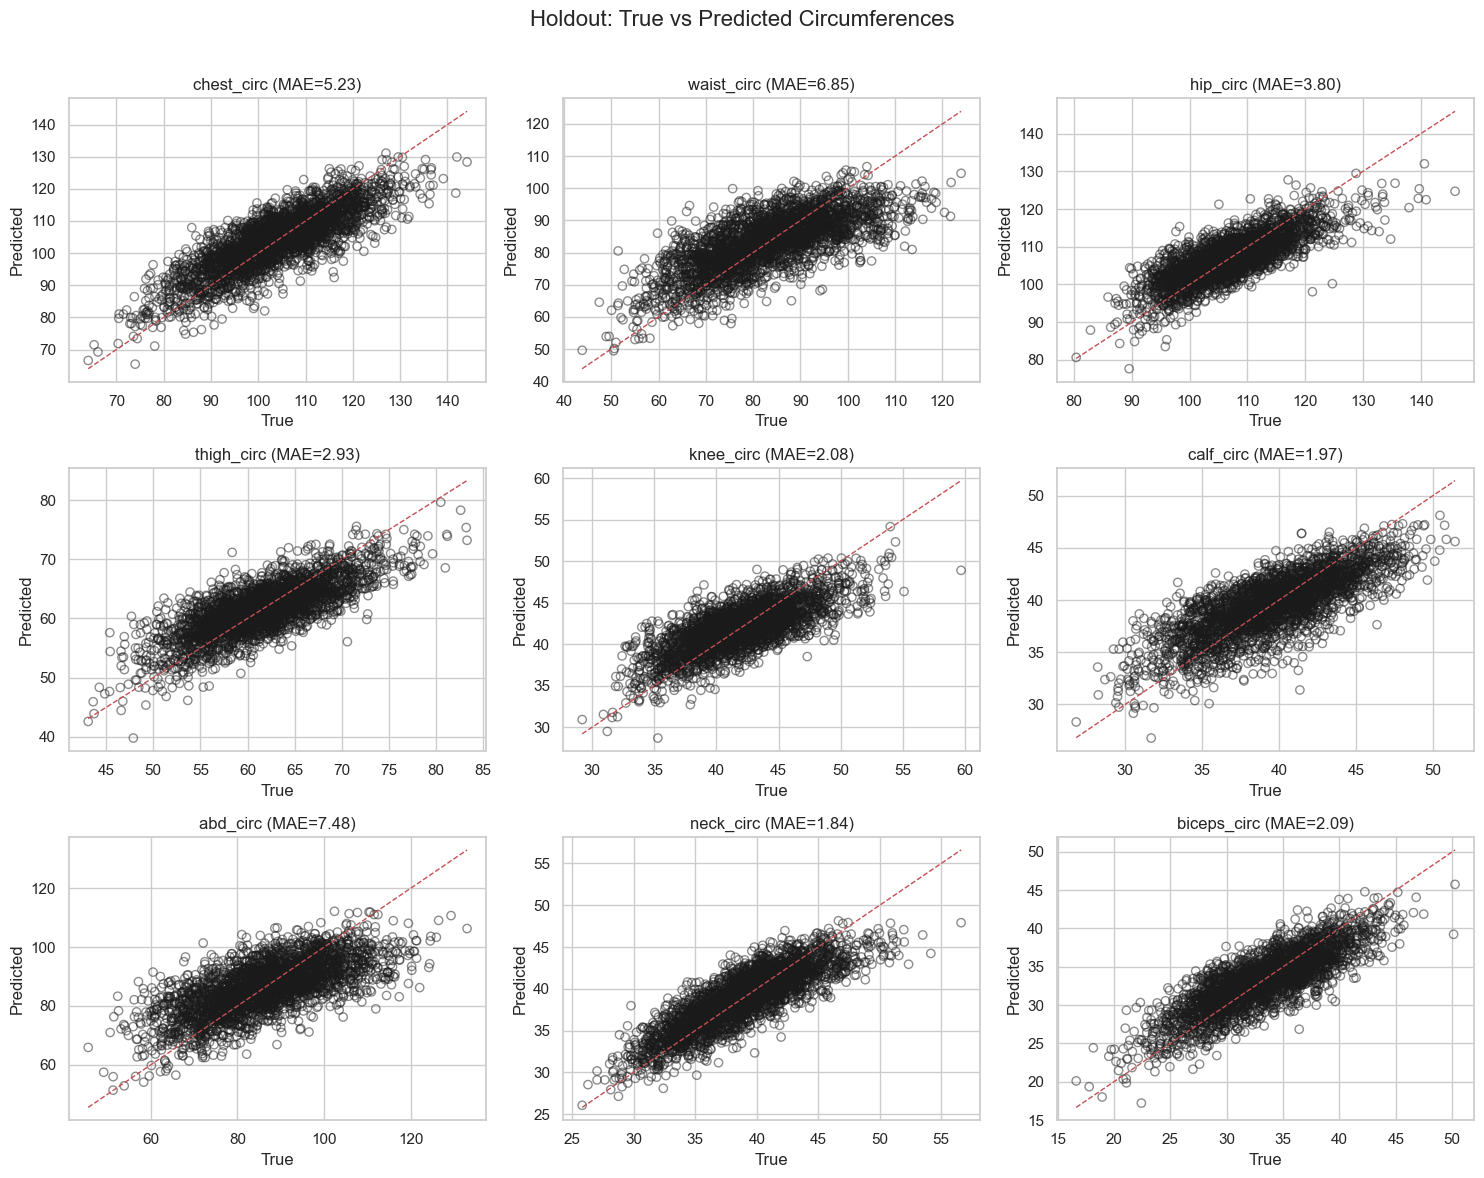

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots pretty
sns.set(style="whitegrid", context="notebook")

n_targets = len(TARGETS)
ncols = 3
nrows = int(np.ceil(n_targets / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4*nrows))

for i, t in enumerate(TARGETS):
    ax = axes.flat[i]
    yt, yp = Yva[:, i], Yhat[:, i]
    
    # scatter
    ax.scatter(yt, yp, alpha=0.5, edgecolor="k", facecolor="none")
    
    # 45° line (perfect predictions)
    minv, maxv = yt.min(), yt.max()
    ax.plot([minv, maxv], [minv, maxv], "r--", lw=1)
    
    # labels & title
    ax.set_title(f"{t} (MAE={mean_absolute_error(yt, yp):.2f})")
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")

# Remove unused subplots if any
for j in range(i+1, len(axes.flat)):
    fig.delaxes(axes.flat[j])

fig.suptitle("Holdout: True vs Predicted Circumferences", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [5]:
from ultralytics import YOLO
import os, joblib, pandas as pd, numpy as np

# ---- Set parameters directly (instead of argparse) ----
ID = "syn_f000000-0-Pre"   # example
IMGDIR = "data/mulheres_15k"
WEIGHTS = "yolov8m-pose.pt"
MODEL_PATH = "models/yolo_ridge.joblib"

# ---- File paths ----
front = os.path.join(IMGDIR, f"{ID}/front.png")
side  = os.path.join(IMGDIR, f"{ID}/side.png")

# ---- Load YOLO pose model ----
model_pose = YOLO(WEIGHTS)

# ---- Run pose estimation ----
fkp = run_pose(model_pose, front)
skp = run_pose(model_pose, side) if os.path.exists(side) else None

# ---- Extract features ----
feats, px_map = feature_vector(fkp, skp)

# Normalize by height (keep doing it the same way you trained)
H = max(float(feats.get("front_height_px", 1.0)), 1.0)
feats_norm = {k: (v / H) if k.endswith("_px") else v for k, v in feats.items()}

# ---- Load model pack (has model, targets, and the exact feature_names used in training) ----
pack = joblib.load(MODEL_PATH)
model = pack["model"]
targets = pack["targets"]
feature_names = pack["feature_names"]  # e.g. 10 features (no front_height_px)

# ---- Build X strictly in the trained order; ignore extras, fill any missing with 0.0 ----
row = {f: float(feats_norm.get(f, 0.0)) for f in feature_names}

# (optional) sanity prints
extra = sorted(set(feats_norm) - set(feature_names))
missing = [f for f in feature_names if f not in feats_norm]
if extra:
    print("Note: ignoring extra features not used by the model:", extra)
if missing:
    print("Warning: missing features, filled with 0.0:", missing)

X = pd.DataFrame([row], columns=feature_names).values

# ---- Predict ----
yhat = model.predict(X)[0]

# ---- Show results nicely ----
px_df = pd.DataFrame([px_map], index=["pixels (front)"]).T
pred_df = pd.DataFrame({"measure": targets, "prediction": yhat})

display(px_df)
display(pred_df)


Note: ignoring extra features not used by the model: ['front_height_px']


,pixels (front)
pescoço_px,22.031656
peito_px,104.360477
cintura_px,98.708588
quadril_px,66.677521
coxa_px,67.036678
joelho_px,67.475647
panturrilha_px,60.421436
abdomen_px,100.686749
biceps_px,173.823065


,measure,prediction
0,chest_circ,314.522029
1,waist_circ,259.641899
2,hip_circ,302.967677
3,thigh_circ,195.830291
4,knee_circ,118.378015
5,calf_circ,120.344155
6,abd_circ,275.418822
7,neck_circ,97.791610
8,biceps_circ,117.188315


In [9]:
import numpy as np

def normalize_keypoints(kps):
    """
    Coerce various YOLO/pose outputs to a (17, 3) float array: [x, y, conf].
    Accepts shapes like (17,2), (17,3), (1,17,2/3), or (N,17,2/3) -> picks the first person.
    """
    if kps is None:
        return None

    arr = np.asarray(kps)

    # If multiple persons or batch dim, pick the first
    if arr.ndim == 3:
        # shapes like (N, 17, 2/3) or (1, 17, 2/3)
        arr = arr[0]
    elif arr.ndim != 2:
        raise ValueError(f"Unsupported keypoints ndim={arr.ndim}; expected 2D or 3D")

    if arr.shape[0] != 17:
        raise ValueError(f"Expected 17 keypoints, got {arr.shape[0]}")

    # Add confidence if missing
    if arr.shape[1] == 2:
        conf = np.ones((arr.shape[0], 1), dtype=float)
        arr = np.concatenate([arr.astype(float), conf], axis=1)
    elif arr.shape[1] == 3:
        arr = arr.astype(float)
    else:
        raise ValueError(f"Last dim must be 2 or 3, got {arr.shape[1]}")

    return arr


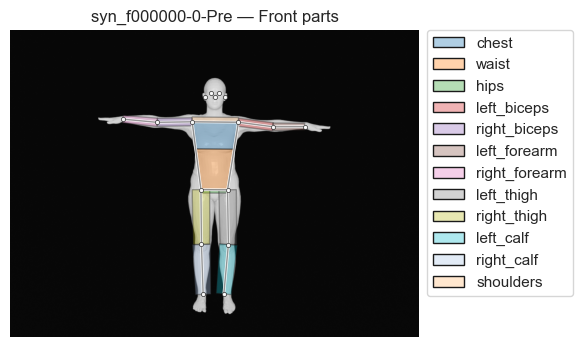

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import imageio.v2 as imageio

# ============== Keypoint utilities ==============

# COCO 17-keypoint indices (YOLOv8 Pose)
K = {
    "nose": 0, "left_eye": 1, "right_eye": 2, "left_ear": 3, "right_ear": 4,
    "left_shoulder": 5, "right_shoulder": 6, "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10, "left_hip": 11, "right_hip": 12,
    "left_knee": 13, "right_knee": 14, "left_ankle": 15, "right_ankle": 16
}

# Skeleton pairs (for drawing lines)
SKELETON = [
    (K["left_shoulder"], K["right_shoulder"]),
    (K["left_shoulder"], K["left_elbow"]),
    (K["left_elbow"], K["left_wrist"]),
    (K["right_shoulder"], K["right_elbow"]),
    (K["right_elbow"], K["right_wrist"]),
    (K["left_hip"], K["right_hip"]),
    (K["left_shoulder"], K["left_hip"]),
    (K["right_shoulder"], K["right_hip"]),
    (K["left_hip"], K["left_knee"]),
    (K["left_knee"], K["left_ankle"]),
    (K["right_hip"], K["right_knee"]),
    (K["right_knee"], K["right_ankle"])
]

def normalize_keypoints(kps):
    """
    Coerce various YOLO/pose outputs to a (17, 3) float array: [x, y, conf].
    Accepts shapes like (17,2), (17,3), (1,17,2/3), or (N,17,2/3) -> picks the first person.
    """
    if kps is None:
        return None
    arr = np.asarray(kps)

    # If multiple persons or batch dim, pick the first
    if arr.ndim == 3:
        arr = arr[0]
    elif arr.ndim != 2:
        raise ValueError(f"Unsupported keypoints ndim={arr.ndim}; expected 2D or 3D")

    if arr.shape[0] != 17:
        raise ValueError(f"Expected 17 keypoints, got {arr.shape[0]}")

    # Add confidence if missing
    if arr.shape[1] == 2:
        conf = np.ones((arr.shape[0], 1), dtype=float)
        arr = np.concatenate([arr.astype(float), conf], axis=1)
    elif arr.shape[1] == 3:
        arr = arr.astype(float)
    else:
        raise ValueError(f"Last dim must be 2 or 3, got {arr.shape[1]}")
    return arr

# Helper: fetch (x, y) if conf >= thresh; else None
def get(kps, idx, conf_thresh=0.2):
    if kps is None:
        return None
    if idx < 0 or idx >= len(kps):
        return None
    x, y, c = kps[idx]
    return (float(x), float(y)) if c >= conf_thresh else None

def mid(p, q):
    if p is None or q is None:
        return None
    return ((p[0]+q[0])/2.0, (p[1]+q[1])/2.0)

# ============== Shape builders ==============

def limb_quad(p1, p2, width=12):
    """Simple rectangle around segment p1->p2 with fixed half-width (pixels)."""
    if p1 is None or p2 is None:
        return None
    vx, vy = p2[0]-p1[0], p2[1]-p1[1]
    n = np.hypot(vx, vy)
    if n < 1e-3:
        return None
    nx, ny = -vy/n, vx/n  # perpendicular unit
    A = (p1[0] + nx*width, p1[1] + ny*width)
    B = (p2[0] + nx*width, p2[1] + ny*width)
    C = (p2[0] - nx*width, p2[1] - ny*width)
    D = (p1[0] - nx*width, p1[1] - ny*width)
    return [A, B, C, D]

def limb_tapered_quad(p_top, p_bot, scale=0.18, taper=0.85):
    """
    Tapered quad around segment p_top->p_bot. Good for 'whole calf' coverage.
      - scale: fraction of segment length used as half-width near the top
      - taper: width multiplier at the bottom (ankle). <1 narrows at the end.
    """
    if p_top is None or p_bot is None:
        return None
    x1, y1 = p_top
    x2, y2 = p_bot
    vx, vy = x2 - x1, y2 - y1
    L = np.hypot(vx, vy)
    if L < 1e-3:
        return None
    nx, ny = -vy / L, vx / L  # perpendicular unit
    w_top = L * scale
    w_bot = w_top * taper
    A = (x1 + nx * w_top, y1 + ny * w_top)
    B = (x2 + nx * w_bot, y2 + ny * w_bot)
    C = (x2 - nx * w_bot, y2 - ny * w_bot)
    D = (x1 - nx * w_top, y1 - ny * w_top)
    return [A, B, C, D]

# ============== Part assembler ==============

def assemble_body_parts(kps):
    LSh = get(kps, K["left_shoulder"])
    RSh = get(kps, K["right_shoulder"])
    LH  = get(kps, K["left_hip"])
    RH  = get(kps, K["right_hip"])
    LE  = get(kps, K["left_elbow"])
    RE  = get(kps, K["right_elbow"])
    LW  = get(kps, K["left_wrist"])
    RW  = get(kps, K["right_wrist"])
    LK  = get(kps, K["left_knee"])
    RK  = get(kps, K["right_knee"])
    LA  = get(kps, K["left_ankle"])
    RA  = get(kps, K["right_ankle"])

    parts = {}

    # ---- Torso (chest/waist) via shoulders/hips interpolation ----
    if LSh and RSh and LH and RH:
        t = 0.4  # divider ratio from shoulders->hips
        L_div = (LSh[0]*(1-t) + LH[0]*t, LSh[1]*(1-t) + LH[1]*t)
        R_div = (RSh[0]*(1-t) + RH[0]*t, RSh[1]*(1-t) + RH[1]*t)
        parts["chest"] = [LSh, RSh, R_div, L_div]
        parts["waist"] = [L_div, R_div, RH, LH]

    # Hips band
    if LH and RH:
        # thin quad just below the hip line (scaled by torso height)
        torso_h = 0.5 * (abs(LH[1] - (LSh[1] if LSh else LH[1])) + abs(RH[1] - (RSh[1] if RSh else RH[1])))
        offset = 0.05 * torso_h
        L_low = (LH[0], LH[1] + offset)
        R_low = (RH[0], RH[1] + offset)
        parts["hips"] = [LH, RH, R_low, L_low]

    # ---- Arms ----
    parts["left_biceps"]   = limb_quad(LSh, LE, width=10)
    parts["right_biceps"]  = limb_quad(RSh, RE, width=10)
    parts["left_forearm"]  = limb_tapered_quad(LE, LW, scale=0.12, taper=0.90)
    parts["right_forearm"] = limb_tapered_quad(RE, RW, scale=0.12, taper=0.90)

    # ---- Legs: thighs + (full) calves ----
    parts["left_thigh"]    = limb_tapered_quad(LH, LK, scale=0.16, taper=0.95)
    parts["right_thigh"]   = limb_tapered_quad(RH, RK, scale=0.16, taper=0.95)
    parts["left_calf"]     = limb_tapered_quad(LK, LA, scale=0.18, taper=0.85)   # fuller calf
    parts["right_calf"]    = limb_tapered_quad(RK, RA, scale=0.18, taper=0.85)   # fuller calf

    # Optional: shoulders band
    if LSh and RSh:
        offset = -12
        L_up = (LSh[0], LSh[1] + offset)
        R_up = (RSh[0], RSh[1] + offset)
        parts["shoulders"] = [L_up, R_up, RSh, LSh]

    # Clean out None entries
    parts = {name: poly for name, poly in parts.items() if poly is not None}
    return parts

# ============== Drawing ==============

def draw_pose_overlay(image_path, keypoints, title="Pose overlay", alpha=0.35):
    """
    keypoints must be (17,3) [x,y,conf]; call normalize_keypoints(...) first if needed.
    """
    img = imageio.imread(image_path)

    # Assemble polygons
    parts = assemble_body_parts(keypoints)

    # Distinct colors per part
    colors = {
        "chest": "#1f77b4",
        "waist": "#ff7f0e",
        "hips": "#2ca02c",
        "left_biceps": "#d62728",
        "right_biceps": "#9467bd",
        "left_forearm": "#8c564b",
        "right_forearm": "#e377c2",
        "left_thigh": "#7f7f7f",
        "right_thigh": "#bcbd22",
        "left_calf": "#17becf",
        "right_calf": "#aec7e8",
        "shoulders": "#ffbb78",
    }

    # Figure
    plt.figure(figsize=(6, 8))
    plt.imshow(img)
    ax = plt.gca()

    # Draw parts
    legend_handles = []
    for name, poly in parts.items():
        col = colors.get(name, None)  # can be None -> default cycle
        patch = Polygon(poly, closed=True, facecolor=col, edgecolor="k",
                        linewidth=1.0, alpha=alpha)
        ax.add_patch(patch)
        legend_handles.append(mpatches.Patch(facecolor=patch.get_facecolor(),
                                             edgecolor="k", label=name))

    # Draw skeleton
    for i, j in SKELETON:
        p1 = get(keypoints, i)
        p2 = get(keypoints, j)
        if p1 and p2:
            ax.add_line(mlines.Line2D([p1[0], p2[0]], [p1[1], p2[1]],
                                      linewidth=2, color="white", alpha=0.9))
            ax.add_line(mlines.Line2D([p1[0], p2[0]], [p1[1], p2[1]],
                                      linewidth=1, color="black", alpha=0.4))

    # Draw joints
    for idx in range(17):
        p = get(keypoints, idx)
        if p:
            ax.plot(p[0], p[1], "wo", markersize=3,
                    markeredgecolor="k", markeredgewidth=0.5, alpha=0.9)

    ax.set_title(title)
    ax.axis("off")

    # Legend outside
    if legend_handles:
        plt.legend(handles=legend_handles, bbox_to_anchor=(1.02, 1),
                   loc="upper left", borderaxespad=0.0)
    plt.tight_layout()
    plt.show()

# ============== Run on your detections ==============

# Ensure fkp/skp are (17,3)
fkp_n = normalize_keypoints(fkp)
draw_pose_overlay(front, fkp_n, title=f"{ID} — Front parts")

if skp is not None:
    skp_n = normalize_keypoints(skp)
    draw_pose_overlay(side, skp_n, title=f"{ID} — Side parts")


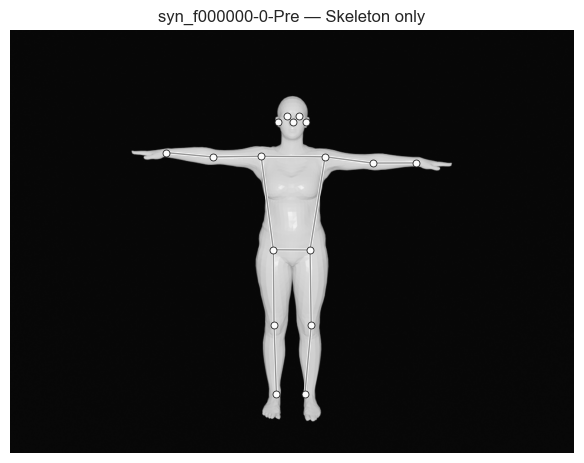

In [11]:
def draw_pose_skeleton(image_path, keypoints, title="Pose skeleton only"):
    img = imageio.imread(image_path)

    plt.figure(figsize=(6, 8))
    plt.imshow(img)
    ax = plt.gca()

    # Draw skeleton lines (white with thin black outline for visibility)
    for i, j in SKELETON:
        p1 = get(keypoints, i)
        p2 = get(keypoints, j)
        if p1 and p2:
            ax.add_line(mlines.Line2D([p1[0], p2[0]], [p1[1], p2[1]],
                                      linewidth=2, color="white", alpha=0.9))
            ax.add_line(mlines.Line2D([p1[0], p2[0]], [p1[1], p2[1]],
                                      linewidth=1, color="black", alpha=0.4))

    # Draw joints (white circles with black edge)
    for idx in range(17):
        p = get(keypoints, idx)
        if p:
            ax.plot(p[0], p[1], "wo", markersize=5,
                    markeredgecolor="k", markeredgewidth=0.6, alpha=0.95)

    ax.set_title(title)
    ax.axis("off")
    plt.tight_layout()
    plt.show()

# Example usage:
fkp_n = normalize_keypoints(fkp)
draw_pose_skeleton(front, fkp_n, title=f"{ID} — Skeleton only")


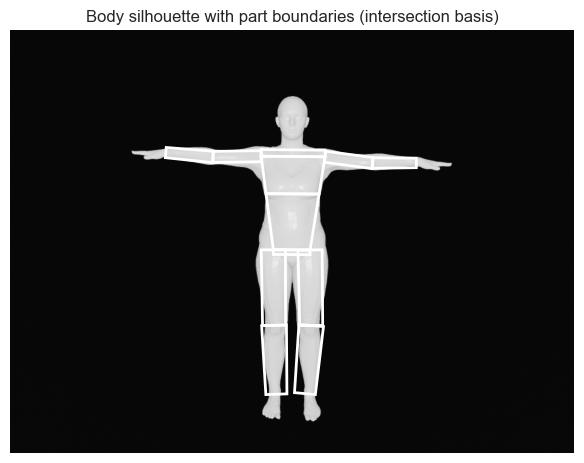

Pixel areas (front):
       chest: 7278
       waist: 8409
        hips: 680
 left_biceps: 1745
right_biceps: 1772
left_forearm: 1415
right_forearm: 1718
  left_thigh: 5858
 right_thigh: 5802
   left_calf: 4012
  right_calf: 4144
   shoulders: 1406


In [12]:
import numpy as np
from PIL import Image, ImageDraw, ImageFilter
import imageio.v2 as imageio
import matplotlib.pyplot as plt

# ---- 1) Body mask from image (no overlays) ----
def otsu_threshold(gray):
    """Minimal Otsu implementation (no skimage/cv2 needed)."""
    hist, bin_edges = np.histogram(gray.ravel(), bins=256, range=(0, 255))
    total = gray.size
    sum_total = np.dot(np.arange(256), hist)
    sumB, wB, wF, var_max, thresh = 0.0, 0, 0, 0.0, 0
    for t in range(256):
        wB += hist[t]
        if wB == 0:
            continue
        wF = total - wB
        if wF == 0:
            break
        sumB += t * hist[t]
        mB = sumB / wB
        mF = (sum_total - sumB) / wF
        var_between = wB * wF * (mB - mF) ** 2
        if var_between > var_max:
            var_max = var_between
            thresh = t
    return thresh

def body_mask_from_image(image_path, keep_largest=True):
    """
    Returns a boolean mask for the subject silhouette.
    Assumes black background and bright gray/white body.
    """
    img = imageio.imread(image_path)
    if img.ndim == 3:
        gray = (0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]).astype(np.uint8)
    else:
        gray = img.astype(np.uint8)

    # Otsu threshold to separate subject from background
    t = otsu_threshold(gray)
    # Subject should be the brighter class; keep pixels > t
    mask = gray > t

    # Optional: keep the largest connected component (remove small specks)
    if keep_largest:
        # simple NCC without external libs: label-ish via flood fill from top candidates
        # fallback: approximate by removing tiny regions via area threshold
        # Here: remove small holes/noise by a tiny morphological close via PIL
        pil = Image.fromarray(mask.astype(np.uint8)*255)
        mask = np.array(pil.convert("L").filter(ImageFilter.MedianFilter(size=3))) > 0  # requires ImageFilter
        # If ImageFilter isn’t desired, skip; most images with black bg won’t need this.

    return mask

# ---- 2) Rasterize polygon -> mask ----
def polygon_to_mask(shape_hw, polygon_xy):
    """
    shape_hw: (H, W)
    polygon_xy: list of (x, y) vertices in image pixel coords
    Returns boolean mask with True inside polygon.
    """
    H, W = shape_hw
    img = Image.new("L", (W, H), 0)
    if polygon_xy is None or len(polygon_xy) < 3:
        return np.zeros((H, W), dtype=bool)
    # PIL expects (x, y) tuples
    ImageDraw.Draw(img).polygon(polygon_xy, outline=1, fill=1)
    return np.array(img, dtype=bool)

# ---- 3) Compute per-part areas by intersection with body mask ----
def part_areas_in_body(image_path, keypoints, parts_fn=assemble_body_parts, visualize=True, alpha=0.35):
    """
    Builds polygons, masks them, intersects with body silhouette, and returns pixel areas per part.
    """
    # raw image (no overlays)
    img = imageio.imread(image_path)
    H, W = img.shape[:2]

    # body silhouette mask
    body_mask = body_mask_from_image(image_path)

    # parts from keypoints
    parts = parts_fn(keypoints)

    areas = {}
    masks = {}

    for name, poly in parts.items():
        m_poly = polygon_to_mask((H, W), poly)
        m_part = m_poly & body_mask
        areas[name] = int(m_part.sum())
        masks[name] = m_part

    if visualize:
        # Overlay: body silhouette (light), plus each part’s mask boundary
        plt.figure(figsize=(6, 8))
        plt.imshow(img)
        ax = plt.gca()

        # faint body silhouette
        body_vis = np.zeros((H, W, 4), dtype=float)
        body_vis[body_mask] = [0.9, 0.9, 0.9, 0.35]  # light gray alpha
        ax.imshow(body_vis)

        # draw part polygons with no fill (just edges)
        for name, poly in parts.items():
            patch = Polygon(poly, closed=True, fill=False, edgecolor="white", linewidth=2)
            ax.add_patch(patch)

        ax.set_title("Body silhouette with part boundaries (intersection basis)")
        ax.axis("off")
        plt.tight_layout()
        plt.show()

    return areas, masks, body_mask

# ================== RUN ==================
# Use the raw image (without any previously drawn overlays)
fkp_n = normalize_keypoints(fkp)
areas_front, masks_front, body_front = part_areas_in_body(front, fkp_n, visualize=True)

print("Pixel areas (front):")
for k, v in areas_front.items():
    print(f"{k:>12s}: {v}")


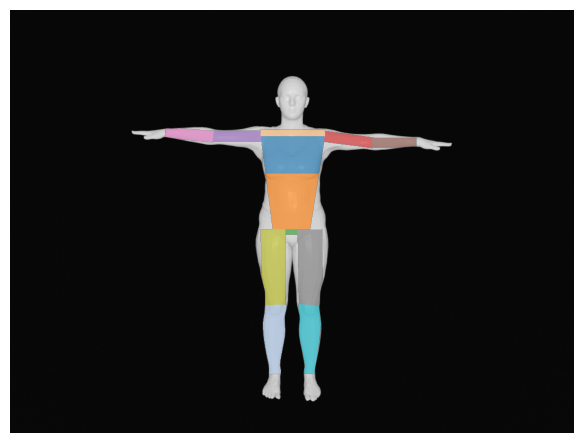

Pixel areas (clipped to body silhouette):
       chest: 7278
        hips: 680
 left_biceps: 1745
   left_calf: 4010
left_forearm: 1415
  left_thigh: 5858
right_biceps: 1772
  right_calf: 4144
right_forearm: 1718
 right_thigh: 5802
   shoulders: 1406
       waist: 8409
Total body pixels: 62264


In [13]:
import numpy as np
from PIL import Image, ImageDraw  # (no ImageFilter needed)
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# ---- Silhouette mask (white/gray subject on black background) ----
def otsu_threshold(gray):
    hist, _ = np.histogram(gray.ravel(), bins=256, range=(0, 255))
    total = gray.size
    sum_total = np.dot(np.arange(256), hist)
    sumB = 0.0
    wB = 0
    var_max, thresh = 0.0, 0
    for t in range(256):
        wB += hist[t]
        if wB == 0: 
            continue
        wF = total - wB
        if wF == 0: 
            break
        sumB += t * hist[t]
        mB = sumB / wB
        mF = (sum_total - sumB) / wF
        var_between = wB * wF * (mB - mF) ** 2
        if var_between > var_max:
            var_max, thresh = var_between, t
    return thresh

def body_mask_from_image(image_path, force_thresh=None):
    img = imageio.imread(image_path)
    if img.ndim == 3:
        gray = (0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]).astype(np.uint8)
    else:
        gray = img.astype(np.uint8)
    t = int(force_thresh) if force_thresh is not None else otsu_threshold(gray)
    # body is brighter than background
    return (gray > t)

# ---- Polygon rasterizer -> boolean mask ----
def polygon_to_mask(shape_hw, polygon_xy):
    H, W = shape_hw
    if polygon_xy is None or len(polygon_xy) < 3:
        return np.zeros((H, W), dtype=bool)
    img = Image.new("L", (W, H), 0)
    ImageDraw.Draw(img).polygon(polygon_xy, outline=1, fill=1)
    return np.array(img, dtype=bool)

# ---- Clip parts to body and compute areas; also visualize only-overlap fill ----
def clip_parts_to_body(image_path, keypoints, parts_fn=assemble_body_parts, show=True):
    img = imageio.imread(image_path)
    H, W = img.shape[:2]

    body_mask = body_mask_from_image(image_path)
    parts = parts_fn(keypoints)  # from your existing code

    # choose distinct RGBA colors
    palette = {
        "chest": (31,119,180,160),
        "waist": (255,127,14,160),
        "hips": (44,160,44,160),
        "left_biceps": (214,39,40,160),
        "right_biceps": (148,103,189,160),
        "left_forearm": (140,86,75,160),
        "right_forearm": (227,119,194,160),
        "left_thigh": (127,127,127,160),
        "right_thigh": (188,189,34,160),
        "left_calf": (23,190,207,160),
        "right_calf": (174,199,232,160),
        "shoulders": (255,187,120,160),
    }

    # RGBA overlay initialized transparent
    overlay = np.zeros((H, W, 4), dtype=np.uint8)
    areas_px = {}

    for name, poly in parts.items():
        m_poly = polygon_to_mask((H, W), poly)
        m_clip = m_poly & body_mask                  # <<< intersection here
        areas_px[name] = int(m_clip.sum())

        # paint only where intersected
        r,g,b,a = palette.get(name, (255,255,255,140))
        overlay[m_clip] = (r,g,b,a)

    if show:
        plt.figure(figsize=(6,8))
        plt.imshow(img)
        plt.imshow(overlay)  # only-overlap colors
        ax = plt.gca()
        ax.axis("off")
        plt.tight_layout()
        plt.show()

    return areas_px, body_mask

# ====== RUN (use RAW image path, without previous drawings) ======
fkp_n = normalize_keypoints(fkp)
areas_px, body_mask = clip_parts_to_body(front, fkp_n, show=True)

print("Pixel areas (clipped to body silhouette):")
for k,v in sorted(areas_px.items()):
    print(f"{k:>12s}: {v}")
print("Total body pixels:", int(body_mask.sum()))


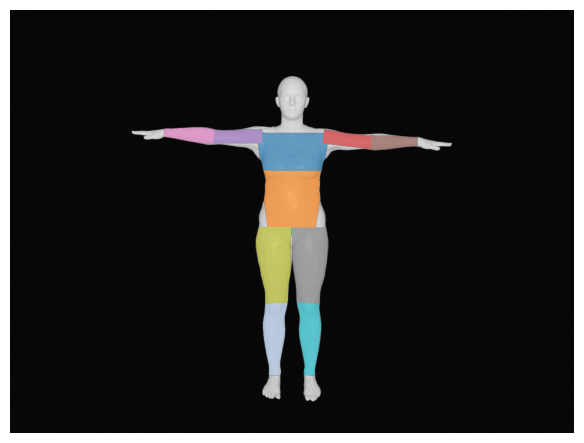

{'chest': 9762, 'waist': 11091, 'hips': 1184, 'left_biceps': 2269, 'right_biceps': 2276, 'left_forearm': 1901, 'right_forearm': 2149, 'left_thigh': 8032, 'right_thigh': 7872, 'left_calf': 4278, 'right_calf': 4338}


In [14]:
import numpy as np
from PIL import Image, ImageDraw, ImageFilter
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# ================== Controls ==================
# 1) Limb geometry: thickness (scale) and distal narrowing (taper)
LIMB_PARAMS = {
    "biceps_scale": 0.12,   "biceps_taper": 0.95,
    "forearm_scale": 0.14,  "forearm_taper": 0.88,
    "thigh_scale": 0.20,    "thigh_taper": 0.95,
    "calf_scale": 0.22,     "calf_taper": 0.82,   # ↑ thicker + a bit tapered
}

# 2) Torso split: how far down from shoulders the chest/waist divider sits
TORSO_DIVIDER_T = 0.42  # move toward 0.5 for a taller chest, toward 0.3 for a shorter chest

# 3) Per-part mask dilation in pixels (applied after polygon -> mask)
#    (Good for “make chest 6px wider on each side”, etc.)
EXPAND_PX = {
    "chest": 6,
    "waist": 8,
    "hips": 3,
    "left_biceps": 2,
    "right_biceps": 2,
    "left_forearm": 2,
    "right_forearm": 2,
    "left_thigh": 4,
    "right_thigh": 4,
    "left_calf": 3,
    "right_calf": 3,
    "shoulders": 2,
}

# ================== Existing helpers ==================
# Your K, SKELETON, normalize_keypoints, get, mid as before...
K = {
    "nose": 0, "left_eye": 1, "right_eye": 2, "left_ear": 3, "right_ear": 4,
    "left_shoulder": 5, "right_shoulder": 6, "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10, "left_hip": 11, "right_hip": 12,
    "left_knee": 13, "right_knee": 14, "left_ankle": 15, "right_ankle": 16
}
SKELETON = [
    (K["left_shoulder"], K["right_shoulder"]),
    (K["left_shoulder"], K["left_elbow"]),
    (K["left_elbow"], K["left_wrist"]),
    (K["right_shoulder"], K["right_elbow"]),
    (K["right_elbow"], K["right_wrist"]),
    (K["left_hip"], K["right_hip"]),
    (K["left_shoulder"], K["left_hip"]),
    (K["right_shoulder"], K["right_hip"]),
    (K["left_hip"], K["left_knee"]),
    (K["left_knee"], K["left_ankle"]),
    (K["right_hip"], K["right_knee"]),
    (K["right_knee"], K["right_ankle"])
]

def normalize_keypoints(kps):
    arr = np.asarray(kps)
    if arr.ndim == 3:
        arr = arr[0]
    if arr.shape[0] != 17:
        raise ValueError("Expected 17 keypoints")
    if arr.shape[1] == 2:
        arr = np.concatenate([arr.astype(float), np.ones((17,1), float)], axis=1)
    return arr.astype(float)

def get(kps, idx, conf_thresh=0.2):
    if kps is None or not (0 <= idx < len(kps)):
        return None
    x, y, c = kps[idx]
    return (float(x), float(y)) if c >= conf_thresh else None

def mid(p, q):
    if p is None or q is None: 
        return None
    return ((p[0]+q[0])/2.0, (p[1]+q[1])/2.0)

# ================== Geometry builders ==================
def limb_tapered_quad(p_top, p_bot, scale=0.18, taper=0.85):
    if p_top is None or p_bot is None:
        return None
    x1, y1 = p_top; x2, y2 = p_bot
    vx, vy = x2-x1, y2-y1
    L = np.hypot(vx, vy)
    if L < 1e-3:
        return None
    nx, ny = -vy/L, vx/L  # perpendicular unit
    w_top = L*scale
    w_bot = w_top*taper
    A = (x1 + nx*w_top, y1 + ny*w_top)
    B = (x2 + nx*w_bot, y2 + ny*w_bot)
    C = (x2 - nx*w_bot, y2 - ny*w_bot)
    D = (x1 - nx*w_top, y1 - ny*w_top)
    return [A, B, C, D]

def assemble_body_parts(kps):
    LSh = get(kps, K["left_shoulder"]); RSh = get(kps, K["right_shoulder"])
    LH  = get(kps, K["left_hip"]);      RH  = get(kps, K["right_hip"])
    LE  = get(kps, K["left_elbow"]);    RE  = get(kps, K["right_elbow"])
    LW  = get(kps, K["left_wrist"]);    RW  = get(kps, K["right_wrist"])
    LK  = get(kps, K["left_knee"]);     RK  = get(kps, K["right_knee"])
    LA  = get(kps, K["left_ankle"]);    RA  = get(kps, K["right_ankle"])

    parts = {}

    # Torso (adjust divider)
    if LSh and RSh and LH and RH:
        t = float(TORSO_DIVIDER_T)
        L_div = (LSh[0]*(1-t) + LH[0]*t, LSh[1]*(1-t) + LH[1]*t)
        R_div = (RSh[0]*(1-t) + RH[0]*t, RSh[1]*(1-t) + RH[1]*t)
        parts["chest"] = [LSh, RSh, R_div, L_div]
        parts["waist"] = [L_div, R_div, RH, LH]

    # Hips band (thin)
    if LH and RH:
        torso_h = 0.5*(abs(LH[1] - (LSh[1] if LSh else LH[1])) + abs(RH[1] - (RSh[1] if RSh else RH[1])))
        offset = 0.05*torso_h
        L_low = (LH[0], LH[1] + offset); R_low = (RH[0], RH[1] + offset)
        parts["hips"] = [LH, RH, R_low, L_low]

    # Arms
    parts["left_biceps"]   = limb_tapered_quad(LSh, LE, scale=LIMB_PARAMS["biceps_scale"],  taper=LIMB_PARAMS["biceps_taper"])
    parts["right_biceps"]  = limb_tapered_quad(RSh, RE, scale=LIMB_PARAMS["biceps_scale"],  taper=LIMB_PARAMS["biceps_taper"])
    parts["left_forearm"]  = limb_tapered_quad(LE,  LW, scale=LIMB_PARAMS["forearm_scale"], taper=LIMB_PARAMS["forearm_taper"])
    parts["right_forearm"] = limb_tapered_quad(RE,  RW, scale=LIMB_PARAMS["forearm_scale"], taper=LIMB_PARAMS["forearm_taper"])

    # Legs
    parts["left_thigh"]    = limb_tapered_quad(LH,  LK, scale=LIMB_PARAMS["thigh_scale"],   taper=LIMB_PARAMS["thigh_taper"])
    parts["right_thigh"]   = limb_tapered_quad(RH,  RK, scale=LIMB_PARAMS["thigh_scale"],   taper=LIMB_PARAMS["thigh_taper"])
    parts["left_calf"]     = limb_tapered_quad(LK,  LA, scale=LIMB_PARAMS["calf_scale"],    taper=LIMB_PARAMS["calf_taper"])
    parts["right_calf"]    = limb_tapered_quad(RK,  RA, scale=LIMB_PARAMS["calf_scale"],    taper=LIMB_PARAMS["calf_taper"])

    return {n:p for n,p in parts.items() if p is not None}

# ================== Masking (clip to body) ==================
def otsu_threshold(gray):
    hist, _ = np.histogram(gray.ravel(), bins=256, range=(0, 255))
    total = gray.size; sum_total = np.dot(np.arange(256), hist)
    sumB = 0.0; wB = 0; var_max = 0.0; thresh = 0
    for t in range(256):
        wB += hist[t]
        if wB == 0: continue
        wF = total - wB
        if wF == 0: break
        sumB += t*hist[t]
        mB = sumB / wB
        mF = (sum_total - sumB) / wF
        var_between = wB*wF*(mB - mF)**2
        if var_between > var_max:
            var_max, thresh = var_between, t
    return thresh

def body_mask_from_image(image_path, force_thresh=None):
    img = imageio.imread(image_path)
    gray = (0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]).astype(np.uint8) if img.ndim==3 else img.astype(np.uint8)
    t = int(force_thresh) if force_thresh is not None else otsu_threshold(gray)
    return gray > t  # white/gray body on black bg

def polygon_to_mask(shape_hw, polygon_xy):
    H, W = shape_hw
    if not polygon_xy or len(polygon_xy) < 3:
        return np.zeros((H, W), dtype=bool)
    img = Image.new("L", (W, H), 0)
    ImageDraw.Draw(img).polygon(polygon_xy, outline=1, fill=1)
    return np.array(img, dtype=bool)

def dilate_mask_bool(mask, pixels):
    """Dilate a boolean mask by ~'pixels' using PIL MaxFilter."""
    if pixels <= 0: 
        return mask
    size = 2*int(pixels) + 1
    pil = Image.fromarray((mask.astype(np.uint8)*255))
    dil = pil.filter(ImageFilter.MaxFilter(size=size))
    return np.array(dil) > 0

def clip_parts_to_body_with_expand(image_path, keypoints, show=True):
    img = imageio.imread(image_path)
    H, W = img.shape[:2]
    body = body_mask_from_image(image_path)
    parts = assemble_body_parts(keypoints)

    overlay = np.zeros((H, W, 4), dtype=np.uint8)
    areas_px = {}

    # simple palette
    palette = {
        "chest": (31,119,180,160), "waist": (255,127,14,160), "hips": (44,160,44,160),
        "left_biceps": (214,39,40,160), "right_biceps": (148,103,189,160),
        "left_forearm": (140,86,75,160), "right_forearm": (227,119,194,160),
        "left_thigh": (127,127,127,160), "right_thigh": (188,189,34,160),
        "left_calf": (23,190,207,160), "right_calf": (174,199,232,160),
        "shoulders": (255,187,120,160),
    }

    for name, poly in parts.items():
        m = polygon_to_mask((H, W), poly)
        # --- PER-PART DILATION HERE ---
        m = dilate_mask_bool(m, EXPAND_PX.get(name, 0))
        # clip to body silhouette
        m_clip = m & body
        areas_px[name] = int(m_clip.sum())
        r,g,b,a = palette.get(name, (255,255,255,140))
        overlay[m_clip] = (r,g,b,a)

    if show:
        plt.figure(figsize=(6,8))
        plt.imshow(img); plt.imshow(overlay)
        plt.axis("off"); plt.tight_layout(); plt.show()

    return areas_px

# ================== RUN ==================
fkp_n = normalize_keypoints(fkp)
areas = clip_parts_to_body_with_expand(front, fkp_n, show=True)
print(areas)


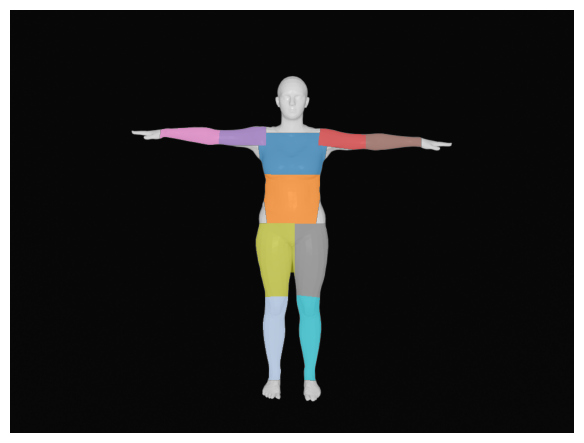

{'chest': 10446, 'waist': 10351, 'hips': 1184, 'left_biceps': 3184, 'right_biceps': 3279, 'left_forearm': 2405, 'right_forearm': 2561, 'left_thigh': 9575, 'right_thigh': 9345, 'left_calf': 4984, 'right_calf': 5013}


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFilter
import imageio.v2 as imageio

# ------------------ CONFIG ------------------
CFG = dict(
    # limbs: half-width is scale * segment_length (top), taper multiplies the bottom half-width
    biceps_scale=0.14,   biceps_taper=0.95,
    forearm_scale=0.16,  forearm_taper=0.88,
    thigh_scale=0.22,    thigh_taper=0.95,
    calf_scale=0.24,     calf_taper=0.82,

    # small overlaps at joints (pixels) so parts meet seamlessly
    elbow_overlap_px=8,
    knee_overlap_px=10,

    # torso divider (0=at shoulders, 1=at hips); higher makes the chest taller
    torso_divider_t=0.46,

    # mask smoothing (applied per part after clipping to body)
    smooth_close_px=3,  # 0 to disable; 2-5 usually good

    # extra “grow” per part (pixels) before clipping (set 0 to disable)
    expand_px={
        "chest": 6, "waist": 8, "hips": 3,
        "left_biceps": 3, "right_biceps": 3,
        "left_forearm": 3, "right_forearm": 3,
        "left_thigh": 5, "right_thigh": 5,
        "left_calf": 5, "right_calf": 5,
    }
)

# ------------------ COCO indices ------------------
K = {
    "nose": 0, "left_eye": 1, "right_eye": 2, "left_ear": 3, "right_ear": 4,
    "left_shoulder": 5, "right_shoulder": 6, "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10, "left_hip": 11, "right_hip": 12,
    "left_knee": 13, "right_knee": 14, "left_ankle": 15, "right_ankle": 16
}

# ------------------ Keypoint helpers ------------------
def normalize_keypoints(kps):
    arr = np.asarray(kps)
    if arr.ndim == 3: arr = arr[0]
    if arr.shape[0] != 17: raise ValueError("Expected 17 kpts")
    if arr.shape[1] == 2:
        arr = np.concatenate([arr.astype(float), np.ones((17,1), float)], axis=1)
    return arr.astype(float)

def get(kps, idx, conf_thresh=0.2):
    x, y, c = kps[idx]
    return (float(x), float(y)) if c >= conf_thresh else None

def lerp(p, q, t):
    return (p[0]*(1-t) + q[0]*t, p[1]*(1-t) + q[1]*t)

# ------------------ Geometry ------------------
def tapered_quad(p_top, p_bot, scale=0.18, taper=0.85, extra_top=0.0, extra_bot=0.0):
    """Tapered quad around p_top->p_bot, with optional extension beyond both ends (pixels)."""
    if p_top is None or p_bot is None: return None
    x1,y1 = p_top; x2,y2 = p_bot
    vx,vy = x2-x1, y2-y1
    L = np.hypot(vx,vy)
    if L < 1e-3: return None
    ux,uy = vx/L, vy/L
    nx,ny = -uy, ux  # perpendicular
    # extend endpoints (overlap at joints)
    x1e, y1e = x1 - ux*extra_top,  y1 - uy*extra_top
    x2e, y2e = x2 + ux*extra_bot,  y2 + uy*extra_bot
    L2 = np.hypot(x2e-x1e, y2e-y1e)
    w_top = L2*scale
    w_bot = w_top*taper
    A = (x1e + nx*w_top, y1e + ny*w_top)
    B = (x2e + nx*w_bot, y2e + ny*w_bot)
    C = (x2e - nx*w_bot, y2e - ny*w_bot)
    D = (x1e - nx*w_top, y1e - ny*w_top)
    return [A,B,C,D]

def torso_polys(LSh, RSh, LH, RH, t_div):
    """Chest + waist trapezoids bounded by shoulders and hips with a divider."""
    if not (LSh and RSh and LH and RH): return {}
    Ldiv = lerp(LSh, LH, t_div)
    Rdiv = lerp(RSh, RH, t_div)
    chest = [LSh, RSh, Rdiv, Ldiv]
    waist = [Ldiv, Rdiv, RH, LH]
    # slim hips band just below the hip line
    torso_h = 0.5*(abs(LH[1]-LSh[1]) + abs(RH[1]-RSh[1]))
    off = 0.05*torso_h
    L_low = (LH[0], LH[1]+off); R_low = (RH[0], RH[1]+off)
    hips = [LH, RH, R_low, L_low]
    return {"chest": chest, "waist": waist, "hips": hips}

# ------------------ Masks ------------------
def otsu_threshold(gray):
    hist, _ = np.histogram(gray.ravel(), bins=256, range=(0,255))
    total = gray.size; sum_total = np.dot(np.arange(256), hist)
    sumB=wB=0; var_max=0; thresh=0
    for t in range(256):
        wB += hist[t]
        if wB==0: continue
        wF = total - wB
        if wF==0: break
        sumB += t*hist[t]
        mB = sumB/wB
        mF = (sum_total - sumB)/wF
        var_between = wB*wF*(mB-mF)**2
        if var_between > var_max:
            var_max, thresh = var_between, t
    return thresh

def body_mask_from_image(image_path, force_thresh=None):
    img = imageio.imread(image_path)
    gray = (0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]).astype(np.uint8) if img.ndim==3 else img.astype(np.uint8)
    t = int(force_thresh) if force_thresh is not None else otsu_threshold(gray)
    return gray > t

def poly_to_mask(shape_hw, poly):
    H, W = shape_hw
    if not poly or len(poly)<3: return np.zeros((H,W), bool)
    m = Image.new("L", (W,H), 0)
    ImageDraw.Draw(m).polygon(poly, outline=1, fill=1)
    return np.array(m, dtype=bool)

def grow(mask, px):
    if px<=0: return mask
    size = 2*int(px)+1
    pil = Image.fromarray(mask.astype(np.uint8)*255)
    return (pil.filter(ImageFilter.MaxFilter(size=size)).point(lambda v: 255 if v>0 else 0)).convert("1")

def close_mask(mask, px):
    """dilate then erode ~px to smooth edges."""
    if px<=0: return mask
    size = 2*int(px)+1
    pil = Image.fromarray(mask.astype(np.uint8)*255)
    dil = pil.filter(ImageFilter.MaxFilter(size=size))
    ero = dil.filter(ImageFilter.MinFilter(size=size))
    return np.array(ero, dtype=np.uint8)>0

# ------------------ Assemble parts ------------------
def assemble_improved_parts(kps):
    LSh=get(kps,K["left_shoulder"]);  RSh=get(kps,K["right_shoulder"])
    LE=get(kps,K["left_elbow"]);      RE=get(kps,K["right_elbow"])
    LW=get(kps,K["left_wrist"]);      RW=get(kps,K["right_wrist"])
    LH=get(kps,K["left_hip"]);        RH=get(kps,K["right_hip"])
    LK=get(kps,K["left_knee"]);       RK=get(kps,K["right_knee"])
    LA=get(kps,K["left_ankle"]);      RA=get(kps,K["right_ankle"])

    parts = {}
    # Torso
    parts.update(torso_polys(LSh,RSh,LH,RH, CFG["torso_divider_t"]))

    # Arms (extend into elbow joint to avoid gaps; small overlap both ends)
    eo = CFG["elbow_overlap_px"]
    parts["left_biceps"]  = tapered_quad(LSh, LE, CFG["biceps_scale"],  CFG["biceps_taper"], extra_top=6, extra_bot=eo)
    parts["right_biceps"] = tapered_quad(RSh, RE, CFG["biceps_scale"],  CFG["biceps_taper"], extra_top=6, extra_bot=eo)
    parts["left_forearm"] = tapered_quad(LE,  LW, CFG["forearm_scale"], CFG["forearm_taper"], extra_top=eo, extra_bot=6)
    parts["right_forearm"]= tapered_quad(RE,  RW, CFG["forearm_scale"], CFG["forearm_taper"], extra_top=eo, extra_bot=6)

    # Legs (overlap at knee/ankle)
    ko = CFG["knee_overlap_px"]
    parts["left_thigh"]   = tapered_quad(LH, LK, CFG["thigh_scale"], CFG["thigh_taper"], extra_top=6, extra_bot=ko)
    parts["right_thigh"]  = tapered_quad(RH, RK, CFG["thigh_scale"], CFG["thigh_taper"], extra_top=6, extra_bot=ko)
    parts["left_calf"]    = tapered_quad(LK, LA, CFG["calf_scale"],  CFG["calf_taper"], extra_top=ko, extra_bot=6)
    parts["right_calf"]   = tapered_quad(RK, RA, CFG["calf_scale"],  CFG["calf_taper"], extra_top=ko, extra_bot=6)

    return {n:p for n,p in parts.items() if p is not None}

# ------------------ Clip & draw ------------------
def clip_and_draw_parts(image_path, keypoints, show=True):
    img = imageio.imread(image_path)
    H, W = img.shape[:2]
    body = body_mask_from_image(image_path)
    parts = assemble_improved_parts(keypoints)

    # colors
    palette = {
        "chest": (31,119,180,170), "waist": (255,127,14,170), "hips": (44,160,44,170),
        "left_biceps": (214,39,40,170), "right_biceps": (148,103,189,170),
        "left_forearm": (140,86,75,170), "right_forearm": (227,119,194,170),
        "left_thigh": (127,127,127,170), "right_thigh": (188,189,34,170),
        "left_calf": (23,190,207,170), "right_calf": (174,199,232,170),
    }

    overlay = np.zeros((H,W,4), np.uint8)
    areas = {}

    for name, poly in parts.items():
        m = poly_to_mask((H,W), poly)

        # optional growth before clipping (use to widen slightly)
        grow_px = CFG["expand_px"].get(name, 0)
        if grow_px>0:
            m = np.array(grow(m, grow_px), dtype=bool)

        # clip to body silhouette
        m = m & body

        # smooth edges (closing)
        m = close_mask(m, CFG["smooth_close_px"])

        areas[name] = int(m.sum())
        r,g,b,a = palette.get(name, (255,255,255,160))
        overlay[m] = (r,g,b,a)

    if show:
        plt.figure(figsize=(6,8))
        plt.imshow(img); plt.imshow(overlay)
        plt.axis("off"); plt.tight_layout(); plt.show()

    return areas

# ------------------ RUN ------------------
fkp_n = normalize_keypoints(fkp)
areas = clip_and_draw_parts(front, fkp_n, show=True)
print(areas)


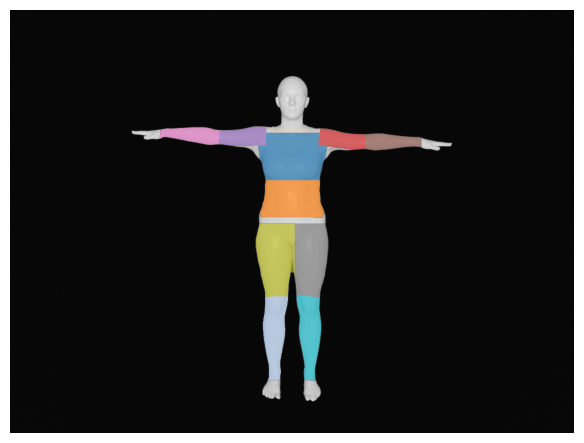

Pixel areas (clipped to body):
       chest: 10446
        hips: 1184
 left_biceps: 3184
   left_calf: 4984
left_forearm: 2405
  left_thigh: 9575
right_biceps: 3279
  right_calf: 5013
right_forearm: 2561
 right_thigh: 9345
       waist: 7048


In [16]:
# =========================
# Body-part overlay (clipped to silhouette) with improved WAIST band
# =========================

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFilter
import imageio.v2 as imageio

# ------------------ CONFIG ------------------
CFG = dict(
    # Limb thickness (half-width = scale * segment_length at the proximal end)
    biceps_scale=0.14,   biceps_taper=0.95,
    forearm_scale=0.16,  forearm_taper=0.88,
    thigh_scale=0.22,    thigh_taper=0.95,
    calf_scale=0.24,     calf_taper=0.82,

    # Overlap at joints so segments meet cleanly (pixels)
    elbow_overlap_px=8,
    knee_overlap_px=10,

    # Torso cuts
    chest_divider_t=0.46,  # 0..1 along shoulder->hip line; higher = taller chest

    # WAIST band controls (top/bottom cuts along shoulder->hip and outward side push)
    waist_top_t=0.52,      # raise to move top of waist up
    waist_bottom_t=0.82,   # raise/lower bottom of waist
    waist_out_px=10,       # lateral outward push (then still clipped to silhouette)

    # Per-part expand (pixels) BEFORE clipping to body (fine-grain shaping)
    expand_px={
        "chest": 6, "waist": 8, "hips": 3,
        "left_biceps": 3, "right_biceps": 3,
        "left_forearm": 3, "right_forearm": 3,
        "left_thigh": 5, "right_thigh": 5,
        "left_calf": 5, "right_calf": 5,
    },

    # Smooth jagged edges (morphological close = dilate->erode ~ px)
    smooth_close_px=3,
)

# ------------------ COCO indices ------------------
K = {
    "nose": 0, "left_eye": 1, "right_eye": 2, "left_ear": 3, "right_ear": 4,
    "left_shoulder": 5, "right_shoulder": 6, "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10, "left_hip": 11, "right_hip": 12,
    "left_knee": 13, "right_knee": 14, "left_ankle": 15, "right_ankle": 16
}

# ------------------ Keypoint helpers ------------------
def normalize_keypoints(kps):
    arr = np.asarray(kps)
    if arr.ndim == 3: arr = arr[0]
    if arr.shape[0] != 17: raise ValueError("Expected 17 keypoints")
    if arr.shape[1] == 2:
        arr = np.concatenate([arr.astype(float), np.ones((17,1), float)], axis=1)
    return arr.astype(float)

def get(kps, idx, conf_thresh=0.2):
    x, y, c = kps[idx]
    return (float(x), float(y)) if c >= conf_thresh else None

def lerp(p, q, t):
    return (p[0]*(1-t) + q[0]*t, p[1]*(1-t) + q[1]*t)

def _safe_unit(vx, vy):
    n = np.hypot(vx, vy)
    return (vx/n, vy/n) if n > 1e-6 else (0.0, 0.0)

# ------------------ Geometry ------------------
def tapered_quad(p_top, p_bot, scale=0.18, taper=0.85, extra_top=0.0, extra_bot=0.0):
    """Tapered quad around p_top->p_bot, with optional extension beyond both ends (pixels)."""
    if p_top is None or p_bot is None: return None
    x1, y1 = p_top; x2, y2 = p_bot
    vx, vy = x2-x1, y2-y1
    L = np.hypot(vx, vy)
    if L < 1e-3: return None
    ux, uy = vx/L, vy/L
    nx, ny = -uy, ux  # perpendicular
    # extend endpoints to create joint overlaps
    x1e, y1e = x1 - ux*extra_top,  y1 - uy*extra_top
    x2e, y2e = x2 + ux*extra_bot,  y2 + uy*extra_bot
    L2 = np.hypot(x2e-x1e, y2e-y1e)
    w_top = L2*scale
    w_bot = w_top*taper
    A = (x1e + nx*w_top, y1e + ny*w_top)
    B = (x2e + nx*w_bot, y2e + ny*w_bot)
    C = (x2e - nx*w_bot, y2e - ny*w_bot)
    D = (x1e - nx*w_top, y1e - ny*w_top)
    return [A,B,C,D]

def _expand_side_outward(L_pt, R_pt, out_px):
    """Expand left/right points away from their midpoint by out_px."""
    mid = ((L_pt[0] + R_pt[0]) * 0.5, (L_pt[1] + R_pt[1]) * 0.5)
    vL = (L_pt[0] - mid[0], L_pt[1] - mid[1])
    vR = (R_pt[0] - mid[0], R_pt[1] - mid[1])
    uL = _safe_unit(*vL); uR = _safe_unit(*vR)
    L_exp = (L_pt[0] + uL[0]*out_px, L_pt[1] + uL[1]*out_px)
    R_exp = (R_pt[0] + uR[0]*out_px, R_pt[1] + uR[1]*out_px)
    return L_exp, R_exp

def improved_torso_polys(LSh, RSh, LH, RH, chest_div_t, waist_top_t, waist_bot_t, waist_out_px):
    """
    Chest: shoulders -> chest_div_t cut.
    Waist: true band between waist_top_t and waist_bot_t with lateral outward push.
    Hips: thin band below the hip line.
    """
    parts = {}
    if not (LSh and RSh and LH and RH):
        return parts

    # Chest cut
    L_ch = lerp(LSh, LH, chest_div_t)
    R_ch = lerp(RSh, RH, chest_div_t)
    parts["chest"] = [LSh, RSh, R_ch, L_ch]

    # Waist band (top/bottom cuts along sides)
    L_top = lerp(LSh, LH, waist_top_t)
    R_top = lerp(RSh, RH, waist_top_t)
    L_bot = lerp(LSh, LH, waist_bot_t)
    R_bot = lerp(RSh, RH, waist_bot_t)

    # push sides outward at both cuts
    L_top_e, R_top_e = _expand_side_outward(L_top, R_top, waist_out_px)
    L_bot_e, R_bot_e = _expand_side_outward(L_bot, R_bot, waist_out_px)
    parts["waist"] = [L_top_e, R_top_e, R_bot_e, L_bot_e]

    # Hips band
    torso_h = 0.5*(abs(LH[1]-LSh[1]) + abs(RH[1]-RSh[1]))
    off = 0.05*torso_h
    L_low = (LH[0], LH[1]+off); R_low = (RH[0], RH[1]+off)
    parts["hips"] = [LH, RH, R_low, L_low]
    return parts

# ------------------ Silhouette masks ------------------
def otsu_threshold(gray):
    hist, _ = np.histogram(gray.ravel(), bins=256, range=(0,255))
    total = gray.size; sum_total = np.dot(np.arange(256), hist)
    sumB=wB=0; var_max=0; thresh=0
    for t in range(256):
        wB += hist[t]
        if wB==0: continue
        wF = total - wB
        if wF==0: break
        sumB += t*hist[t]
        mB = sumB/wB
        mF = (sum_total - sumB)/wF
        var_between = wB*wF*(mB-mF)**2
        if var_between > var_max:
            var_max, thresh = var_between, t
    return thresh

def body_mask_from_image(image_path, force_thresh=None):
    img = imageio.imread(image_path)
    gray = (0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]).astype(np.uint8) if img.ndim==3 else img.astype(np.uint8)
    t = int(force_thresh) if force_thresh is not None else otsu_threshold(gray)
    return gray > t  # white/gray body on black bg

def poly_to_mask(shape_hw, poly):
    H, W = shape_hw
    if not poly or len(poly)<3: return np.zeros((H,W), bool)
    m = Image.new("L", (W, H), 0)
    ImageDraw.Draw(m).polygon(poly, outline=1, fill=1)
    return np.array(m, dtype=bool)

def grow_mask(mask, px):
    if px <= 0:
        return mask
    size = 2*int(px) + 1
    pil = Image.fromarray(mask.astype(np.uint8) * 255)
    grown = pil.filter(ImageFilter.MaxFilter(size=size))   # PIL Image
    return (np.array(grown) > 0)                           # boolean ndarray


def close_mask(mask, px):
    if px<=0: return mask
    size = 2*int(px)+1
    pil = Image.fromarray(mask.astype(np.uint8)*255)
    dil = pil.filter(ImageFilter.MaxFilter(size=size))
    ero = dil.filter(ImageFilter.MinFilter(size=size))
    return np.array(ero, dtype=np.uint8) > 0

# ------------------ Assemble parts ------------------
def assemble_improved_parts(kps):
    LSh=get(kps,K["left_shoulder"]);  RSh=get(kps,K["right_shoulder"])
    LE=get(kps,K["left_elbow"]);      RE=get(kps,K["right_elbow"])
    LW=get(kps,K["left_wrist"]);      RW=get(kps,K["right_wrist"])
    LH=get(kps,K["left_hip"]);        RH=get(kps,K["right_hip"])
    LK=get(kps,K["left_knee"]);       RK=get(kps,K["right_knee"])
    LA=get(kps,K["left_ankle"]);      RA=get(kps,K["right_ankle"])

    parts = {}

    # --- Torso with improved waist band ---
    parts.update(improved_torso_polys(
        LSh, RSh, LH, RH,
        chest_div_t = CFG["chest_divider_t"],
        waist_top_t = CFG["waist_top_t"],
        waist_bot_t = CFG["waist_bottom_t"],
        waist_out_px= CFG["waist_out_px"]
    ))

    # --- Arms (tapered quads with elbow overlap) ---
    eo = CFG["elbow_overlap_px"]
    parts["left_biceps"]  = tapered_quad(LSh, LE, CFG["biceps_scale"],  CFG["biceps_taper"],  extra_top=6,  extra_bot=eo)
    parts["right_biceps"] = tapered_quad(RSh, RE, CFG["biceps_scale"],  CFG["biceps_taper"],  extra_top=6,  extra_bot=eo)
    parts["left_forearm"] = tapered_quad(LE,  LW, CFG["forearm_scale"], CFG["forearm_taper"], extra_top=eo, extra_bot=6)
    parts["right_forearm"]= tapered_quad(RE,  RW, CFG["forearm_scale"], CFG["forearm_taper"], extra_top=eo, extra_bot=6)

    # --- Legs (tapered quads with knee overlap) ---
    ko = CFG["knee_overlap_px"]
    parts["left_thigh"]   = tapered_quad(LH, LK, CFG["thigh_scale"], CFG["thigh_taper"], extra_top=6, extra_bot=ko)
    parts["right_thigh"]  = tapered_quad(RH, RK, CFG["thigh_scale"], CFG["thigh_taper"], extra_top=6, extra_bot=ko)
    parts["left_calf"]    = tapered_quad(LK, LA, CFG["calf_scale"],  CFG["calf_taper"],  extra_top=ko, extra_bot=6)
    parts["right_calf"]   = tapered_quad(RK, RA, CFG["calf_scale"],  CFG["calf_taper"],  extra_top=ko, extra_bot=6)

    return {n:p for n,p in parts.items() if p is not None}

# ------------------ Clip, draw, and area ------------------
def clip_and_draw_parts(image_path, keypoints, show=True):
    img = imageio.imread(image_path)
    H, W = img.shape[:2]
    body = body_mask_from_image(image_path)
    parts = assemble_improved_parts(keypoints)

    # colors (RGBA)
    palette = {
        "chest": (31,119,180,170), "waist": (255,127,14,170), "hips": (44,160,44,170),
        "left_biceps": (214,39,40,170), "right_biceps": (148,103,189,170),
        "left_forearm": (140,86,75,170), "right_forearm": (227,119,194,170),
        "left_thigh": (127,127,127,170), "right_thigh": (188,189,34,170),
        "left_calf": (23,190,207,170), "right_calf": (174,199,232,170),
    }

    overlay = np.zeros((H,W,4), np.uint8)
    areas = {}

    for name, poly in parts.items():
        m = poly_to_mask((H,W), poly)

        # optional growth (per-part) BEFORE clipping
        grow_px = CFG["expand_px"].get(name, 0)
        if grow_px > 0:
            m = grow_mask(m, grow_px)

        # clip to body silhouette
        m = m & body

        # smooth edges
        m = close_mask(m, CFG["smooth_close_px"])

        areas[name] = int(m.sum())
        r,g,b,a = palette.get(name, (255,255,255,160))
        overlay[m] = (r,g,b,a)

    if show:
        plt.figure(figsize=(6,8))
        plt.imshow(img); plt.imshow(overlay)
        plt.axis("off"); plt.tight_layout(); plt.show()

    return areas, overlay

# ------------------ Example RUN ------------------
# Use your existing variables:
#   - front: path to the raw image (without prior drawings)
#   - fkp:   keypoints for that image
#
fkp_n = normalize_keypoints(fkp)
areas, overlay = clip_and_draw_parts(front, fkp_n, show=True)
print("Pixel areas (clipped to body):")
for k,v in sorted(areas.items()):
    print(f"{k:>12s}: {v}")


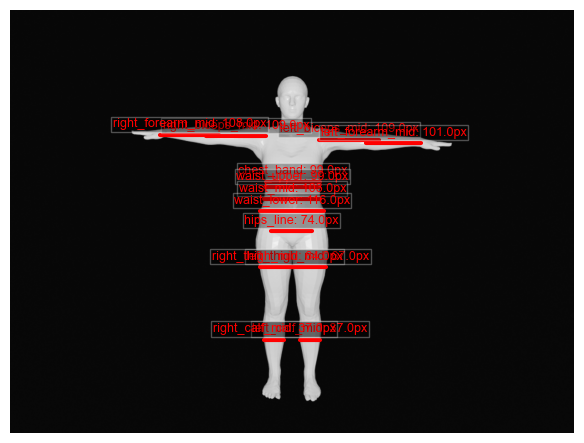

Red-line measurements:
left_biceps_mid   width = 109.0 px
left_forearm_mid  width = 101.0 px
right_biceps_mid  width = 109.0 px
right_forearm_mid  width = 108.0 px
chest_band        width = 99.0 px
waist_upper       width = 99.0 px
waist_mid         width = 103.0 px
waist_lower       width = 116.0 px
hips_line         width = 74.0 px
left_thigh_mid    width = 67.0 px
right_thigh_mid   width = 64.0 px
left_calf_mid     width = 37.0 px
right_calf_mid    width = 37.0 px


In [19]:
# ==== ADD/REPLACE these helpers under your existing code ====

import numpy as np
import matplotlib.pyplot as plt

def _row_segment_width(mask_row):
    """Return (xL, xR, width_px) for the largest contiguous True segment in a 1D boolean row."""
    best = (None, None, 0)
    n = mask_row.size
    i = 0
    while i < n:
        if not mask_row[i]:
            i += 1
            continue
        j = i
        while j < n and mask_row[j]:
            j += 1
        w = j - i
        if w > best[2]:
            best = (i, j-1, w)
        i = j
    return best  # (xL, xR, width)

def _y_between(p_top, p_bot, t):
    """Interpolate y between two keypoints (0..1)."""
    return p_top[1]*(1-t) + p_bot[1]*t

def build_part_masks(image_path, keypoints):
    """
    Re-run your clipping exactly like clip_and_draw_parts but also keep each part mask.
    Returns: parts_masks (dict[str,bool HxW]), body_mask (bool HxW), overlay (HxWx4)
    """
    img = imageio.imread(image_path)
    H, W = img.shape[:2]
    body = body_mask_from_image(image_path)
    parts = assemble_improved_parts(keypoints)

    overlay = np.zeros((H, W, 4), np.uint8)
    parts_masks = {}

    # same palette and smoothing as before
    palette = {
        "chest": (31,119,180,170), "waist": (255,127,14,170), "hips": (44,160,44,170),
        "left_biceps": (214,39,40,170), "right_biceps": (148,103,189,170),
        "left_forearm": (140,86,75,170), "right_forearm": (227,119,194,170),
        "left_thigh": (127,127,127,170), "right_thigh": (188,189,34,170),
        "left_calf": (23,190,207,170), "right_calf": (174,199,232,170),
    }

    for name, poly in parts.items():
        m = poly_to_mask((H, W), poly)
        grow_px = CFG["expand_px"].get(name, 0)
        if grow_px > 0:
            m = grow_mask(m, grow_px)
        m = m & body
        m = close_mask(m, CFG["smooth_close_px"])
        parts_masks[name] = m
        r,g,b,a = palette.get(name, (255,255,255,160))
        overlay[m] = (r,g,b,a)

    return parts_masks, body, overlay

def measure_horizontal_lines(front_image_path, keypoints, parts_masks, body_mask,
                             front_height_px, HEIGHT_CM=None, plot=True):
    """
    Compute left-right widths (px and optional cm) at anatomically defined scanlines.
    Returns: dict[name] = {"y": y, "xL": xL, "xR": xR, "width_px": w, "width_cm": w_cm or None}
    """
    k = keypoints
    H, W = body_mask.shape
    results = {}

    # Scale factor px->cm (optional)
    px_to_cm = None
    if HEIGHT_CM is not None and front_height_px and front_height_px > 0:
        px_to_cm = float(HEIGHT_CM) / float(front_height_px)

    # --- convenient accessors ---
    LSh=get(k,K["left_shoulder"]);  RSh=get(k,K["right_shoulder"])
    LH=get(k,K["left_hip"]);        RH=get(k,K["right_hip"])
    LE=get(k,K["left_elbow"]);      RE=get(k,K["right_elbow"])
    LW=get(k,K["left_wrist"]);      RW=get(k,K["right_wrist"])
    LK=get(k,K["left_knee"]);       RK=get(k,K["right_knee"])
    LA=get(k,K["left_ankle"]);      RA=get(k,K["right_ankle"])

    def _avg_y(y_list):
        ys = [y for y in y_list if y is not None]
        return float(np.mean(ys)) if ys else None

    # ===== Define scanlines (y coordinates) =====
    scan_defs = []

    # Arms (mid-biceps & mid-forearm)
    if LSh and LE:
        y = _y_between(LSh, LE, 0.5); scan_defs.append(("left_biceps_mid", "left_biceps", y))
    if LE and LW:
        y = _y_between(LE, LW, 0.5);   scan_defs.append(("left_forearm_mid", "left_forearm", y))

    if RSh and RE:
        y = _y_between(RSh, RE, 0.5); scan_defs.append(("right_biceps_mid", "right_biceps", y))
    if RE and RW:
        y = _y_between(RE, RW, 0.5);  scan_defs.append(("right_forearm_mid", "right_forearm", y))

    # Chest/waist: three bands along shoulder→hip line
    if LSh and RSh and LH and RH:
        # average left/right y at each t
        def y_t(t):
            return _avg_y([_y_between(LSh, LH, t), _y_between(RSh, RH, t)])
        chest_t  = CFG["chest_divider_t"] + 0.02
        waist_t1 = CFG["waist_top_t"] + 0.02
        waist_t2 = 0.5*(CFG["waist_top_t"] + CFG["waist_bottom_t"])
        waist_t3 = CFG["waist_bottom_t"] - 0.02
        scan_defs += [
            ("chest_band", "chest", y_t(chest_t)),
            ("waist_upper", "waist", y_t(waist_t1)),
            ("waist_mid",   "waist", y_t(waist_t2)),
            ("waist_lower", "waist", y_t(waist_t3)),
        ]
        # hips near hip line
        y_hips = _avg_y([LH[1], RH[1]])
        scan_defs += [("hips_line", "hips", y_hips + 2.0)]

    # Thigh/calf: mid between joints
    if LH and RH and LK and RK:
        y = _avg_y([(LH[1]+LK[1])*0.5, (RH[1]+RK[1])*0.5])
        scan_defs.append(("thigh_mid", "left_thigh", y))  # mask per side, we’ll measure both sides separately below

    if LK and RK and LA and RA:
        y = _avg_y([(LK[1]+LA[1])*0.5, (RK[1]+RA[1])*0.5])
        scan_defs.append(("calf_mid", "left_calf", y))

    # ===== Measure each scanline =====
    # Helper to measure on a given mask name (falls back to body if mask missing)
    def measure_on_mask(name, y, mask_name):
        if y is None: return
        y_int = int(round(np.clip(y, 0, H-1)))
        m = parts_masks.get(mask_name, body_mask)
        row = m[y_int, :]
        xL, xR, w = _row_segment_width(row)
        if w <= 0: return
        w_cm = (w * px_to_cm) if px_to_cm is not None else None
        results[name] = dict(y=float(y_int), xL=float(xL), xR=float(xR),
                             width_px=float(w), width_cm=(None if w_cm is None else float(w_cm)))

    for name, mask_name, y in scan_defs:
        measure_on_mask(name, y, mask_name)

    # Also measure left/right separately for thigh/calf using each side mask (use same y)
    if "thigh_mid" in results:
        y = results["thigh_mid"]["y"]
        for side in ("left_thigh", "right_thigh"):
            measure_on_mask(f"{side}_mid", y, side)
        results.pop("thigh_mid", None)

    if "calf_mid" in results:
        y = results["calf_mid"]["y"]
        for side in ("left_calf", "right_calf"):
            measure_on_mask(f"{side}_mid", y, side)
        results.pop("calf_mid", None)

    # ===== Optional plotting =====
    if plot:
        img = imageio.imread(front_image_path)
        plt.figure(figsize=(6,8))
        plt.imshow(img)
        # draw masks overlay faintly so red lines are visible
        ov = (np.dstack([body_mask*255]*3)).astype(np.uint8)
        plt.imshow(ov, alpha=0.0)  # keep just the image
        for name, r in results.items():
            y = r["y"]; xL = r["xL"]; xR = r["xR"]
            plt.plot([xL, xR], [y, y], color="red", linewidth=3)
            label = f"{name}: {r['width_px']:.1f}px"
            if r["width_cm"] is not None:
                label += f" ({r['width_cm']:.1f} cm)"
            plt.text((xL+xR)/2, y-8, label, color="red",
                     ha="center", va="bottom", fontsize=9, bbox=dict(facecolor="black", alpha=0.3, pad=1))
        plt.axis("off"); plt.tight_layout(); plt.show()

    return results

# ==== HOW TO USE (after you already have fkp_n and feats/feats_norm) ====

# 1) Build masks (clipped to body) – and keep front_height_px for cm conversion
fkp_n = normalize_keypoints(fkp)
parts_masks, body_mask, overlay = build_part_masks(front, fkp_n)

# 2) Pixel→cm scale (optional). If you know the true height in cm, set HEIGHT_CM.
front_height_px = float(feats.get("front_height_px", 0.0))  # from your feature extractor
HEIGHT_CM = None  # e.g., 170.0 if known; otherwise None

# 3) Measure and plot
measurements = measure_horizontal_lines(front, fkp_n, parts_masks, body_mask,
                                        front_height_px=front_height_px,
                                        HEIGHT_CM=HEIGHT_CM,
                                        plot=True)

print("Red-line measurements:")
for k, v in measurements.items():
    if v["width_cm"] is None:
        print(f"{k:16s}  width = {v['width_px']:.1f} px")
    else:
        print(f"{k:16s}  width = {v['width_px']:.1f} px  |  {v['width_cm']:.1f} cm")


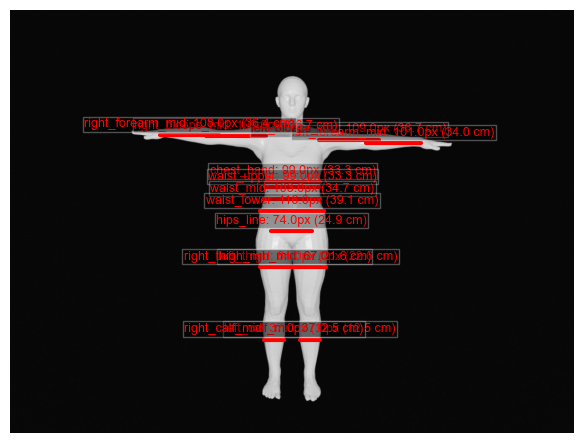

Red-line measurements (converted to cm):
left_biceps_mid   36.72 cm
left_forearm_mid  34.02 cm
right_biceps_mid  36.72 cm
right_forearm_mid  36.38 cm
chest_band        33.35 cm
waist_upper       33.35 cm
waist_mid         34.69 cm
waist_lower       39.07 cm
hips_line         24.93 cm
left_thigh_mid    22.57 cm
right_thigh_mid   21.56 cm
left_calf_mid     12.46 cm
right_calf_mid    12.46 cm


In [20]:
# ==== HOW TO USE (cm conversion enabled) ====

# 1) Build masks
fkp_n = normalize_keypoints(fkp)
parts_masks, body_mask, overlay = build_part_masks(front, fkp_n)

# 2) Pixel→cm scale
front_height_px = float(feats.get("front_height_px", 0.0))  # from your feature extractor
HEIGHT_CM = 170.0   # <-- set this to the person’s actual height in cm

# 3) Measure and plot
measurements = measure_horizontal_lines(
    front,
    fkp_n,
    parts_masks,
    body_mask,
    front_height_px=front_height_px,
    HEIGHT_CM=HEIGHT_CM,
    plot=True
)

# 4) Show results in cm
print("Red-line measurements (converted to cm):")
for k, v in measurements.items():
    print(f"{k:16s}  {v['width_cm']:.2f} cm")


In [21]:
# =========================
# Body-part overlay + measurements
# - Torso/hips/legs: horizontal widths
# - Arms: vertical widths (perpendicular to limb axis)
# =========================

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFilter
import imageio.v2 as imageio

# ------------------ CONFIG ------------------
CFG = dict(
    # Limb thickness (half-width = scale * segment_length at the proximal end)
    biceps_scale=0.14,   biceps_taper=0.95,
    forearm_scale=0.16,  forearm_taper=0.88,
    thigh_scale=0.22,    thigh_taper=0.95,
    calf_scale=0.24,     calf_taper=0.82,

    # Overlap at joints so segments meet cleanly (pixels)
    elbow_overlap_px=8,
    knee_overlap_px=10,

    # Torso cuts
    chest_divider_t=0.46,  # 0..1 along shoulder->hip line; higher = taller chest

    # WAIST band controls (top/bottom cuts along shoulder->hip and outward side push)
    waist_top_t=0.52,
    waist_bottom_t=0.82,
    waist_out_px=10,

    # Per-part expand (pixels) BEFORE clipping to body
    expand_px={
        "chest": 6, "waist": 8, "hips": 3,
        "left_biceps": 3, "right_biceps": 3,
        "left_forearm": 3, "right_forearm": 3,
        "left_thigh": 5, "right_thigh": 5,
        "left_calf": 5, "right_calf": 5,
    },

    # Smooth jagged edges (morphological close = dilate->erode ~ px)
    smooth_close_px=3,
)

# ------------------ COCO indices ------------------
K = {
    "nose": 0, "left_eye": 1, "right_eye": 2, "left_ear": 3, "right_ear": 4,
    "left_shoulder": 5, "right_shoulder": 6, "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10, "left_hip": 11, "right_hip": 12,
    "left_knee": 13, "right_knee": 14, "left_ankle": 15, "right_ankle": 16
}

# ------------------ Keypoint helpers ------------------
def normalize_keypoints(kps):
    arr = np.asarray(kps)
    if arr.ndim == 3:
        arr = arr[0]
    if arr.shape[0] != 17:
        raise ValueError("Expected 17 keypoints")
    if arr.shape[1] == 2:
        arr = np.concatenate([arr.astype(float), np.ones((17,1), float)], axis=1)
    return arr.astype(float)

def get(kps, idx, conf_thresh=0.2):
    x, y, c = kps[idx]
    return (float(x), float(y)) if c >= conf_thresh else None

def lerp(p, q, t):
    return (p[0]*(1-t) + q[0]*t, p[1]*(1-t) + q[1]*t)

def _safe_unit(vx, vy):
    n = np.hypot(vx, vy)
    return (vx/n, vy/n) if n > 1e-6 else (0.0, 0.0)

# ------------------ Geometry (parts) ------------------
def tapered_quad(p_top, p_bot, scale=0.18, taper=0.85, extra_top=0.0, extra_bot=0.0):
    """Tapered quad around p_top->p_bot, with optional extension beyond both ends (pixels)."""
    if p_top is None or p_bot is None:
        return None
    x1, y1 = p_top; x2, y2 = p_bot
    vx, vy = x2-x1, y2-y1
    L = np.hypot(vx, vy)
    if L < 1e-3:
        return None
    ux, uy = vx/L, vy/L
    nx, ny = -uy, ux  # perpendicular
    x1e, y1e = x1 - ux*extra_top,  y1 - uy*extra_top
    x2e, y2e = x2 + ux*extra_bot,  y2 + uy*extra_bot
    L2 = np.hypot(x2e-x1e, y2e-y1e)
    w_top = L2*scale
    w_bot = w_top*taper
    A = (x1e + nx*w_top, y1e + ny*w_top)
    B = (x2e + nx*w_bot, y2e + ny*w_bot)
    C = (x2e - nx*w_bot, y2e - ny*w_bot)
    D = (x1e - nx*w_top, y1e - ny*w_top)
    return [A,B,C,D]

def _expand_side_outward(L_pt, R_pt, out_px):
    mid = ((L_pt[0] + R_pt[0]) * 0.5, (L_pt[1] + R_pt[1]) * 0.5)
    vL = (L_pt[0] - mid[0], L_pt[1] - mid[1])
    vR = (R_pt[0] - mid[0], R_pt[1] - mid[1])
    uL = _safe_unit(*vL); uR = _safe_unit(*vR)
    L_exp = (L_pt[0] + uL[0]*out_px, L_pt[1] + uL[1]*out_px)
    R_exp = (R_pt[0] + uR[0]*out_px, R_pt[1] + uR[1]*out_px)
    return L_exp, R_exp

def improved_torso_polys(LSh, RSh, LH, RH, chest_div_t, waist_top_t, waist_bot_t, waist_out_px):
    parts = {}
    if not (LSh and RSh and LH and RH):
        return parts
    L_ch = lerp(LSh, LH, chest_div_t)
    R_ch = lerp(RSh, RH, chest_div_t)
    parts["chest"] = [LSh, RSh, R_ch, L_ch]

    L_top = lerp(LSh, LH, waist_top_t)
    R_top = lerp(RSh, RH, waist_top_t)
    L_bot = lerp(LSh, LH, waist_bot_t)
    R_bot = lerp(RSh, RH, waist_bot_t)
    L_top_e, R_top_e = _expand_side_outward(L_top, R_top, waist_out_px)
    L_bot_e, R_bot_e = _expand_side_outward(L_bot, R_bot, waist_out_px)
    parts["waist"] = [L_top_e, R_top_e, R_bot_e, L_bot_e]

    torso_h = 0.5*(abs(LH[1]-LSh[1]) + abs(RH[1]-RSh[1]))
    off = 0.05*torso_h
    L_low = (LH[0], LH[1]+off); R_low = (RH[0], RH[1]+off)
    parts["hips"] = [LH, RH, R_low, L_low]
    return parts

# ------------------ Silhouette masks ------------------
def otsu_threshold(gray):
    hist, _ = np.histogram(gray.ravel(), bins=256, range=(0,255))
    total = gray.size; sum_total = np.dot(np.arange(256), hist)
    sumB=wB=0; var_max=0; thresh=0
    for t in range(256):
        wB += hist[t]
        if wB==0: continue
        wF = total - wB
        if wF==0: break
        sumB += t*hist[t]
        mB = sumB/wB
        mF = (sum_total - sumB)/wF
        var_between = wB*wF*(mB-mF)**2
        if var_between > var_max:
            var_max, thresh = var_between, t
    return thresh

def body_mask_from_image(image_path, force_thresh=None):
    img = imageio.imread(image_path)
    gray = (0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]).astype(np.uint8) if img.ndim==3 else img.astype(np.uint8)
    t = int(force_thresh) if force_thresh is not None else otsu_threshold(gray)
    return gray > t  # white/gray body on black bg

def poly_to_mask(shape_hw, poly):
    H, W = shape_hw
    if not poly or len(poly)<3:
        return np.zeros((H,W), bool)
    m = Image.new("L", (W, H), 0)
    ImageDraw.Draw(m).polygon(poly, outline=1, fill=1)
    return np.array(m, dtype=bool)

def grow_mask(mask, px):
    if px <= 0:
        return mask
    size = 2*int(px) + 1
    pil = Image.fromarray(mask.astype(np.uint8) * 255)
    grown = pil.filter(ImageFilter.MaxFilter(size=size))
    return (np.array(grown) > 0)

def close_mask(mask, px):
    if px<=0:
        return mask
    size = 2*int(px)+1
    pil = Image.fromarray(mask.astype(np.uint8)*255)
    dil = pil.filter(ImageFilter.MaxFilter(size=size))
    ero = dil.filter(ImageFilter.MinFilter(size=size))
    return np.array(ero, dtype=np.uint8) > 0

# ------------------ Assemble parts ------------------
def assemble_improved_parts(kps):
    LSh=get(kps,K["left_shoulder"]);  RSh=get(kps,K["right_shoulder"])
    LE=get(kps,K["left_elbow"]);      RE=get(kps,K["right_elbow"])
    LW=get(kps,K["left_wrist"]);      RW=get(kps,K["right_wrist"])
    LH=get(kps,K["left_hip"]);        RH=get(kps,K["right_hip"])
    LK=get(kps,K["left_knee"]);       RK=get(kps,K["right_knee"])
    LA=get(kps,K["left_ankle"]);      RA=get(kps,K["right_ankle"])

    parts = {}
    parts.update(improved_torso_polys(
        LSh, RSh, LH, RH,
        chest_div_t = CFG["chest_divider_t"],
        waist_top_t = CFG["waist_top_t"],
        waist_bot_t = CFG["waist_bottom_t"],
        waist_out_px= CFG["waist_out_px"]
    ))

    eo = CFG["elbow_overlap_px"]
    parts["left_biceps"]  = tapered_quad(LSh, LE, CFG["biceps_scale"],  CFG["biceps_taper"],  extra_top=6,  extra_bot=eo)
    parts["right_biceps"] = tapered_quad(RSh, RE, CFG["biceps_scale"],  CFG["biceps_taper"],  extra_top=6,  extra_bot=eo)
    parts["left_forearm"] = tapered_quad(LE,  LW, CFG["forearm_scale"], CFG["forearm_taper"], extra_top=eo, extra_bot=6)
    parts["right_forearm"]= tapered_quad(RE,  RW, CFG["forearm_scale"], CFG["forearm_taper"], extra_top=eo, extra_bot=6)

    ko = CFG["knee_overlap_px"]
    parts["left_thigh"]   = tapered_quad(LH, LK, CFG["thigh_scale"], CFG["thigh_taper"], extra_top=6, extra_bot=ko)
    parts["right_thigh"]  = tapered_quad(RH, RK, CFG["thigh_scale"], CFG["thigh_taper"], extra_top=6, extra_bot=ko)
    parts["left_calf"]    = tapered_quad(LK, LA, CFG["calf_scale"],  CFG["calf_taper"],  extra_top=ko, extra_bot=6)
    parts["right_calf"]   = tapered_quad(RK, RA, CFG["calf_scale"],  CFG["calf_taper"],  extra_top=ko, extra_bot=6)

    return {n:p for n,p in parts.items() if p is not None}

# ------------------ Build masks (and overlay) ------------------
def build_part_masks(image_path, keypoints):
    """Return parts_masks (dict[str,bool HxW]), body_mask, overlay RGBA."""
    img = imageio.imread(image_path)
    H, W = img.shape[:2]
    body = body_mask_from_image(image_path)
    parts = assemble_improved_parts(keypoints)

    palette = {
        "chest": (31,119,180,170), "waist": (255,127,14,170), "hips": (44,160,44,170),
        "left_biceps": (214,39,40,170), "right_biceps": (148,103,189,170),
        "left_forearm": (140,86,75,170), "right_forearm": (227,119,194,170),
        "left_thigh": (127,127,127,170), "right_thigh": (188,189,34,170),
        "left_calf": (23,190,207,170), "right_calf": (174,199,232,170),
    }

    overlay = np.zeros((H,W,4), np.uint8)
    parts_masks = {}

    for name, poly in parts.items():
        m = poly_to_mask((H,W), poly)
        grow_px = CFG["expand_px"].get(name, 0)
        if grow_px > 0:
            m = grow_mask(m, grow_px)
        m = m & body
        m = close_mask(m, CFG["smooth_close_px"])
        parts_masks[name] = m
        r,g,b,a = palette.get(name, (255,255,255,160))
        overlay[m] = (r,g,b,a)

    return parts_masks, body, overlay

# ------------------ Measurement helpers ------------------
def _row_segment_width(mask_row):
    """Largest contiguous True segment in a 1D boolean row -> (xL, xR, width)."""
    best = (None, None, 0)
    n = mask_row.size
    i = 0
    while i < n:
        if not mask_row[i]:
            i += 1
            continue
        j = i
        while j < n and mask_row[j]:
            j += 1
        w = j - i
        if w > best[2]:
            best = (i, j-1, w)
        i = j
    return best

def _sample_line_points(p0, p1, H, W):
    """Integer pixel coords along segment p0->p1, clipped to image bounds."""
    x0, y0 = p0; x1, y1 = p1
    n = int(max(abs(x1-x0), abs(y1-y0))) + 1
    xs = np.clip(np.rint(np.linspace(x0, x1, n)), 0, W-1).astype(int)
    ys = np.clip(np.rint(np.linspace(y0, y1, n)), 0, H-1).astype(int)
    return xs, ys

def _normal_width_at_midpoint(p_top, p_bot, part_mask, probe_factor=0.9):
    """
    Width along the line perpendicular to limb axis at its midpoint.
    Returns (xL, xR, width_px, y_mid) or None.
    """
    if p_top is None or p_bot is None:
        return None
    x1, y1 = p_top; x2, y2 = p_bot
    vx, vy = x2 - x1, y2 - y1
    L = float(np.hypot(vx, vy))
    if L < 1e-3:
        return None
    # midpoint and unit normal
    mx, my = (x1 + x2) * 0.5, (y1 + y2) * 0.5
    nx, ny = -vy / L, vx / L
    half = probe_factor * L * 0.5
    pA = (mx - nx * half, my - ny * half)
    pB = (mx + nx * half, my + ny * half)
    H, W = part_mask.shape
    xs, ys = _sample_line_points(pA, pB, H, W)
    vals = part_mask[ys, xs]

    xL = xR = None
    best_w = 0
    i = 0
    n = len(vals)
    while i < n:
        if not vals[i]:
            i += 1
            continue
        j = i
        while j < n and vals[j]:
            j += 1
        w = j - i
        if w > best_w:
            best_w = w
            xL = xs[i]; xR = xs[j-1]
        i = j

    if best_w <= 0:
        return None
    return (float(xL), float(xR), float(best_w), float(my))

# ------------------ Main measurement (arms vertical) ------------------
def measure_lines_with_vertical_arms(front_image_path, keypoints, parts_masks, body_mask,
                                     front_height_px, HEIGHT_CM=None, plot=True):
    """
    - Arms: vertical widths (perpendicular to limb axis) at mid-biceps/forearm.
    - Torso/hips/legs: horizontal widths.
    Returns dict[name] with px/cm and draws red lines.
    """
    k = keypoints
    H, W = body_mask.shape
    results = {}

    # px -> cm
    px_to_cm = None
    if HEIGHT_CM is not None and front_height_px and front_height_px > 0:
        px_to_cm = float(HEIGHT_CM) / float(front_height_px)

    # keypoints
    LSh=get(k,K["left_shoulder"]);  RSh=get(k,K["right_shoulder"])
    LE=get(k,K["left_elbow"]);      RE=get(k,K["right_elbow"])
    LW=get(k,K["left_wrist"]);      RW=get(k,K["right_wrist"])
    LH=get(k,K["left_hip"]);        RH=get(k,K["right_hip"])
    LK=get(k,K["left_knee"]);       RK=get(k,K["right_knee"])
    LA=get(k,K["left_ankle"]);      RA=get(k,K["right_ankle"])

    def _avg(vals):
        vals = [v for v in vals if v is not None]
        return float(np.mean(vals)) if vals else None

    # ---------- ARMS (vertical/normal widths) ----------
    if LSh and LE and "left_biceps" in parts_masks:
        res = _normal_width_at_midpoint(LSh, LE, parts_masks["left_biceps"], probe_factor=0.9)
        if res:
            xL, xR, w, y = res
            results["left_biceps_mid_vertical"] = dict(y=y, xL=xL, xR=xR, width_px=w,
                                                       width_cm=(w*px_to_cm if px_to_cm else None))

    if LE and LW and "left_forearm" in parts_masks:
        res = _normal_width_at_midpoint(LE, LW, parts_masks["left_forearm"], probe_factor=0.9)
        if res:
            xL, xR, w, y = res
            results["left_forearm_mid_vertical"] = dict(y=y, xL=xL, xR=xR, width_px=w,
                                                        width_cm=(w*px_to_cm if px_to_cm else None))

    if RSh and RE and "right_biceps" in parts_masks:
        res = _normal_width_at_midpoint(RSh, RE, parts_masks["right_biceps"], probe_factor=0.9)
        if res:
            xL, xR, w, y = res
            results["right_biceps_mid_vertical"] = dict(y=y, xL=xL, xR=xR, width_px=w,
                                                        width_cm=(w*px_to_cm if px_to_cm else None))

    if RE and RW and "right_forearm" in parts_masks:
        res = _normal_width_at_midpoint(RE, RW, parts_masks["right_forearm"], probe_factor=0.9)
        if res:
            xL, xR, w, y = res
            results["right_forearm_mid_vertical"] = dict(y=y, xL=xL, xR=xR, width_px=w,
                                                         width_cm=(w*px_to_cm if px_to_cm else None))

    # ---------- TORSO/HIPS (horizontal) ----------
    def _y_between(p_top, p_bot, t): return p_top[1]*(1-t) + p_bot[1]*t
    if LSh and RSh and LH and RH:
        def y_t(t): return _avg([_y_between(LSh, LH, t), _y_between(RSh, RH, t)])
        chest_t  = CFG["chest_divider_t"] + 0.02
        waist_t1 = CFG["waist_top_t"] + 0.02
        waist_t2 = 0.5*(CFG["waist_top_t"] + CFG["waist_bottom_t"])
        waist_t3 = CFG["waist_bottom_t"] - 0.02
        torso_lines = [
            ("chest_band", "chest", y_t(chest_t)),
            ("waist_upper", "waist", y_t(waist_t1)),
            ("waist_mid",   "waist", y_t(waist_t2)),
            ("waist_lower", "waist", y_t(waist_t3)),
            ("hips_line",   "hips",  _avg([LH[1], RH[1]]) + 2.0),
        ]
        for name, mask_name, y in torso_lines:
            if y is None: continue
            y_int = int(round(np.clip(y, 0, H-1)))
            m = parts_masks.get(mask_name, body_mask)
            row = m[y_int, :]
            xL, xR, w = _row_segment_width(row)
            if w > 0:
                results[name] = dict(y=float(y_int), xL=float(xL), xR=float(xR), width_px=float(w),
                                     width_cm=(float(w)*px_to_cm if px_to_cm else None))

    # ---------- LEGS (horizontal per side) ----------
    def _measure_side(mask_name, y):
        if y is None: return None
        y_int = int(round(np.clip(y, 0, H-1)))
        m = parts_masks.get(mask_name, body_mask)
        row = m[y_int, :]
        xL, xR, w = _row_segment_width(row)
        if w <= 0: return None
        return dict(y=float(y_int), xL=float(xL), xR=float(xR), width_px=float(w),
                    width_cm=(float(w)*px_to_cm if px_to_cm else None))

    if LH and LK:
        yL = (LH[1] + LK[1]) * 0.5
        r = _measure_side("left_thigh", yL)
        if r: results["left_thigh_mid"] = r
    if RH and RK:
        yR = (RH[1] + RK[1]) * 0.5
        r = _measure_side("right_thigh", yR)
        if r: results["right_thigh_mid"] = r

    if LK and LA:
        yL = (LK[1] + LA[1]) * 0.5
        r = _measure_side("left_calf", yL)
        if r: results["left_calf_mid"] = r
    if RK and RA:
        yR = (RK[1] + RA[1]) * 0.5
        r = _measure_side("right_calf", yR)
        if r: results["right_calf_mid"] = r

    # ---------- Plot ----------
    if plot:
        img = imageio.imread(front_image_path)
        plt.figure(figsize=(6,8))
        plt.imshow(img)

        # Draw horizontal lines (torso & legs)
        for name, r in results.items():
            if "vertical" in name: 
                continue
            plt.plot([r["xL"], r["xR"]], [r["y"], r["y"]], color="red", linewidth=3)
            label = f"{name}: {r['width_px']:.1f}px"
            if r["width_cm"] is not None:
                label += f" ({r['width_cm']:.1f} cm)"
            plt.text((r["xL"] + r["xR"]) / 2, r["y"] - 8, label, color="red",
                     ha="center", va="bottom", fontsize=9,
                     bbox=dict(facecolor="black", alpha=0.3, pad=1))

        # Draw arm 'vertical' measures (we show the measured segment; it lies on the normal line)
        for name, r in results.items():
            if "vertical" not in name:
                continue
            plt.plot([r["xL"], r["xR"]], [r["y"], r["y"]], color="red", linewidth=3)
            label = f"{name}: {r['width_px']:.1f}px"
            if r["width_cm"] is not None:
                label += f" ({r['width_cm']:.1f} cm)"
            plt.text((r["xL"] + r["xR"]) / 2, r["y"] - 8, label, color="red",
                     ha="center", va="bottom", fontsize=9,
                     bbox=dict(facecolor="black", alpha=0.3, pad=1))

        plt.axis("off"); plt.tight_layout(); plt.show()

    return results




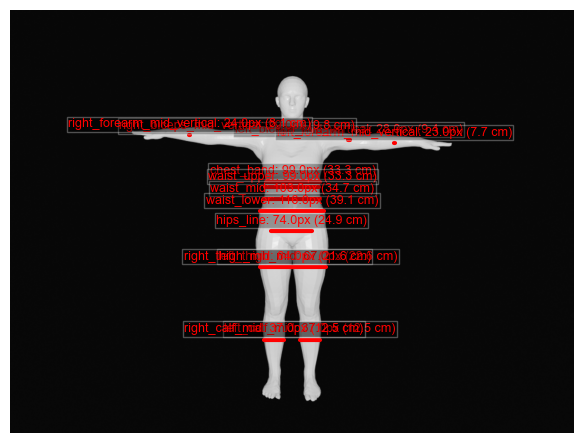

Measurements (cm where available):
left_biceps_mid_vertical     9.43 cm
left_forearm_mid_vertical    7.75 cm
right_biceps_mid_vertical    9.77 cm
right_forearm_mid_vertical   8.08 cm
chest_band                   33.35 cm
waist_upper                  33.35 cm
waist_mid                    34.69 cm
waist_lower                  39.07 cm
hips_line                    24.93 cm
left_thigh_mid               22.57 cm
right_thigh_mid              21.56 cm
left_calf_mid                12.46 cm
right_calf_mid               12.46 cm


In [22]:
#=========================
#EXAMPLE USAGE (paste below your existing fkp/front/feats variables)
#=========================
fkp_n = normalize_keypoints(fkp)
parts_masks, body_mask, overlay = build_part_masks(front, fkp_n)
front_height_px = float(feats.get("front_height_px", 0.0))  # from your feature extractor
HEIGHT_CM = 170.0  # set real person height (cm) for cm conversion; or None for pixels only
measurements = measure_lines_with_vertical_arms(
    front, fkp_n, parts_masks, body_mask,
    front_height_px=front_height_px,
    HEIGHT_CM=HEIGHT_CM,
    plot=True
)
print("Measurements (cm where available):")
for k, v in measurements.items():
    if v["width_cm"] is None:
        print(f"{k:28s} {v['width_px']:.2f} px")
    else:
        print(f"{k:28s} {v['width_cm']:.2f} cm")

In [23]:
# =========================
# Body-part overlay + measurements (no text on image)
# - Torso/hips/legs: horizontal widths
# - Arms: vertical widths (perpendicular to limb axis)
# =========================

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFilter
import imageio.v2 as imageio

# ------------------ CONFIG ------------------
CFG = dict(
    biceps_scale=0.14,   biceps_taper=0.95,
    forearm_scale=0.16,  forearm_taper=0.88,
    thigh_scale=0.22,    thigh_taper=0.95,
    calf_scale=0.24,     calf_taper=0.82,
    elbow_overlap_px=8,
    knee_overlap_px=10,
    chest_divider_t=0.46,
    waist_top_t=0.52,
    waist_bottom_t=0.82,
    waist_out_px=10,
    expand_px={
        "chest": 6, "waist": 8, "hips": 3,
        "left_biceps": 3, "right_biceps": 3,
        "left_forearm": 3, "right_forearm": 3,
        "left_thigh": 5, "right_thigh": 5,
        "left_calf": 5, "right_calf": 5,
    },
    smooth_close_px=3,
)

# ------------------ COCO indices ------------------
K = {
    "nose": 0, "left_eye": 1, "right_eye": 2, "left_ear": 3, "right_ear": 4,
    "left_shoulder": 5, "right_shoulder": 6, "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10, "left_hip": 11, "right_hip": 12,
    "left_knee": 13, "right_knee": 14, "left_ankle": 15, "right_ankle": 16
}

# ------------------ Keypoint helpers ------------------
def normalize_keypoints(kps):
    arr = np.asarray(kps)
    if arr.ndim == 3: arr = arr[0]
    if arr.shape[0] != 17: raise ValueError("Expected 17 keypoints")
    if arr.shape[1] == 2:
        arr = np.concatenate([arr.astype(float), np.ones((17,1), float)], axis=1)
    return arr.astype(float)

def get(kps, idx, conf_thresh=0.2):
    x, y, c = kps[idx]
    return (float(x), float(y)) if c >= conf_thresh else None

def lerp(p, q, t):
    return (p[0]*(1-t) + q[0]*t, p[1]*(1-t) + q[1]*t)

def _safe_unit(vx, vy):
    n = np.hypot(vx, vy)
    return (vx/n, vy/n) if n > 1e-6 else (0.0, 0.0)

# ------------------ Geometry (parts) ------------------
def tapered_quad(p_top, p_bot, scale=0.18, taper=0.85, extra_top=0.0, extra_bot=0.0):
    if p_top is None or p_bot is None: return None
    x1, y1 = p_top; x2, y2 = p_bot
    vx, vy = x2-x1, y2-y1
    L = np.hypot(vx, vy)
    if L < 1e-3: return None
    ux, uy = vx/L, vy/L
    nx, ny = -uy, ux
    x1e, y1e = x1 - ux*extra_top,  y1 - uy*extra_top
    x2e, y2e = x2 + ux*extra_bot,  y2 + uy*extra_bot
    L2 = np.hypot(x2e-x1e, y2e-y1e)
    w_top = L2*scale
    w_bot = w_top*taper
    A = (x1e + nx*w_top, y1e + ny*w_top)
    B = (x2e + nx*w_bot, y2e + ny*w_bot)
    C = (x2e - nx*w_bot, y2e - ny*w_bot)
    D = (x1e - nx*w_top, y1e - ny*w_top)
    return [A,B,C,D]

def _expand_side_outward(L_pt, R_pt, out_px):
    mid = ((L_pt[0] + R_pt[0]) * 0.5, (L_pt[1] + R_pt[1]) * 0.5)
    vL = (L_pt[0] - mid[0], L_pt[1] - mid[1])
    vR = (R_pt[0] - mid[0], R_pt[1] - mid[1])
    uL = _safe_unit(*vL); uR = _safe_unit(*vR)
    L_exp = (L_pt[0] + uL[0]*out_px, L_pt[1] + uL[1]*out_px)
    R_exp = (R_pt[0] + uR[0]*out_px, R_pt[1] + uR[1]*out_px)
    return L_exp, R_exp

def improved_torso_polys(LSh, RSh, LH, RH, chest_div_t, waist_top_t, waist_bot_t, waist_out_px):
    parts = {}
    if not (LSh and RSh and LH and RH): return parts
    L_ch = lerp(LSh, LH, chest_div_t)
    R_ch = lerp(RSh, RH, chest_div_t)
    parts["chest"] = [LSh, RSh, R_ch, L_ch]
    L_top = lerp(LSh, LH, waist_top_t)
    R_top = lerp(RSh, RH, waist_top_t)
    L_bot = lerp(LSh, LH, waist_bot_t)
    R_bot = lerp(RSh, RH, waist_bot_t)
    L_top_e, R_top_e = _expand_side_outward(L_top, R_top, waist_out_px)
    L_bot_e, R_bot_e = _expand_side_outward(L_bot, R_bot, waist_out_px)
    parts["waist"] = [L_top_e, R_top_e, R_bot_e, L_bot_e]
    torso_h = 0.5*(abs(LH[1]-LSh[1]) + abs(RH[1]-RSh[1]))
    off = 0.05*torso_h
    L_low = (LH[0], LH[1]+off); R_low = (RH[0], RH[1]+off)
    parts["hips"] = [LH, RH, R_low, L_low]
    return parts

# ------------------ Silhouette masks ------------------
def otsu_threshold(gray):
    hist, _ = np.histogram(gray.ravel(), bins=256, range=(0,255))
    total = gray.size; sum_total = np.dot(np.arange(256), hist)
    sumB=wB=0; var_max=0; thresh=0
    for t in range(256):
        wB += hist[t]
        if wB==0: continue
        wF = total - wB
        if wF==0: break
        sumB += t*hist[t]
        mB = sumB/wB
        mF = (sum_total - sumB)/wF
        var_between = wB*wF*(mB-mF)**2
        if var_between > var_max:
            var_max, thresh = var_between, t
    return thresh

def body_mask_from_image(image_path, force_thresh=None):
    img = imageio.imread(image_path)
    gray = (0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]).astype(np.uint8) if img.ndim==3 else img.astype(np.uint8)
    t = int(force_thresh) if force_thresh is not None else otsu_threshold(gray)
    return gray > t

def poly_to_mask(shape_hw, poly):
    H, W = shape_hw
    if not poly or len(poly)<3: return np.zeros((H,W), bool)
    m = Image.new("L", (W, H), 0)
    ImageDraw.Draw(m).polygon(poly, outline=1, fill=1)
    return np.array(m, dtype=bool)

def grow_mask(mask, px):
    if px <= 0: return mask
    size = 2*int(px) + 1
    pil = Image.fromarray(mask.astype(np.uint8) * 255)
    grown = pil.filter(ImageFilter.MaxFilter(size=size))
    return (np.array(grown) > 0)

def close_mask(mask, px):
    if px<=0: return mask
    size = 2*int(px)+1
    pil = Image.fromarray(mask.astype(np.uint8)*255)
    dil = pil.filter(ImageFilter.MaxFilter(size=size))
    ero = dil.filter(ImageFilter.MinFilter(size=size))
    return np.array(ero, dtype=np.uint8) > 0

# ------------------ Assemble parts ------------------
def assemble_improved_parts(kps):
    LSh=get(kps,K["left_shoulder"]);  RSh=get(kps,K["right_shoulder"])
    LE=get(kps,K["left_elbow"]);      RE=get(kps,K["right_elbow"])
    LW=get(kps,K["left_wrist"]);      RW=get(kps,K["right_wrist"])
    LH=get(kps,K["left_hip"]);        RH=get(kps,K["right_hip"])
    LK=get(kps,K["left_knee"]);       RK=get(kps,K["right_knee"])
    LA=get(kps,K["left_ankle"]);      RA=get(kps,K["right_ankle"])
    parts = {}
    parts.update(improved_torso_polys(
        LSh, RSh, LH, RH,
        chest_div_t = CFG["chest_divider_t"],
        waist_top_t = CFG["waist_top_t"],
        waist_bot_t = CFG["waist_bottom_t"],
        waist_out_px= CFG["waist_out_px"]
    ))
    eo = CFG["elbow_overlap_px"]
    parts["left_biceps"]  = tapered_quad(LSh, LE, CFG["biceps_scale"],  CFG["biceps_taper"],  extra_top=6,  extra_bot=eo)
    parts["right_biceps"] = tapered_quad(RSh, RE, CFG["biceps_scale"],  CFG["biceps_taper"],  extra_top=6,  extra_bot=eo)
    parts["left_forearm"] = tapered_quad(LE,  LW, CFG["forearm_scale"], CFG["forearm_taper"], extra_top=eo, extra_bot=6)
    parts["right_forearm"]= tapered_quad(RE,  RW, CFG["forearm_scale"], CFG["forearm_taper"], extra_top=eo, extra_bot=6)
    ko = CFG["knee_overlap_px"]
    parts["left_thigh"]   = tapered_quad(LH, LK, CFG["thigh_scale"], CFG["thigh_taper"], extra_top=6, extra_bot=ko)
    parts["right_thigh"]  = tapered_quad(RH, RK, CFG["thigh_scale"], CFG["thigh_taper"], extra_top=6, extra_bot=ko)
    parts["left_calf"]    = tapered_quad(LK, LA, CFG["calf_scale"],  CFG["calf_taper"],  extra_top=ko, extra_bot=6)
    parts["right_calf"]   = tapered_quad(RK, RA, CFG["calf_scale"],  CFG["calf_taper"],  extra_top=ko, extra_bot=6)
    return {n:p for n,p in parts.items() if p is not None}

# ------------------ Build masks (and overlay) ------------------
def build_part_masks(image_path, keypoints):
    img = imageio.imread(image_path)
    H, W = img.shape[:2]
    body = body_mask_from_image(image_path)
    parts = assemble_improved_parts(keypoints)
    palette = {
        "chest": (31,119,180,170), "waist": (255,127,14,170), "hips": (44,160,44,170),
        "left_biceps": (214,39,40,170), "right_biceps": (148,103,189,170),
        "left_forearm": (140,86,75,170), "right_forearm": (227,119,194,170),
        "left_thigh": (127,127,127,170), "right_thigh": (188,189,34,170),
        "left_calf": (23,190,207,170), "right_calf": (174,199,232,170),
    }
    overlay = np.zeros((H,W,4), np.uint8)
    parts_masks = {}
    for name, poly in parts.items():
        m = poly_to_mask((H,W), poly)
        grow_px = CFG["expand_px"].get(name, 0)
        if grow_px > 0: m = grow_mask(m, grow_px)
        m = m & body
        m = close_mask(m, CFG["smooth_close_px"])
        parts_masks[name] = m
        r,g,b,a = palette.get(name, (255,255,255,160))
        overlay[m] = (r,g,b,a)
    return parts_masks, body, overlay

# ------------------ Measurement helpers ------------------
def _row_segment_width(mask_row):
    best = (None, None, 0); n = mask_row.size; i = 0
    while i < n:
        if not mask_row[i]: i += 1; continue
        j = i
        while j < n and mask_row[j]: j += 1
        w = j - i
        if w > best[2]: best = (i, j-1, w)
        i = j
    return best

def _sample_line_points(p0, p1, H, W):
    x0, y0 = p0; x1, y1 = p1
    n = int(max(abs(x1-x0), abs(y1-y0))) + 1
    xs = np.clip(np.rint(np.linspace(x0, x1, n)), 0, W-1).astype(int)
    ys = np.clip(np.rint(np.linspace(y0, y1, n)), 0, H-1).astype(int)
    return xs, ys

def _normal_width_at_midpoint(p_top, p_bot, part_mask, probe_factor=0.9):
    if p_top is None or p_bot is None: return None
    x1, y1 = p_top; x2, y2 = p_bot
    vx, vy = x2 - x1, y2 - y1
    L = float(np.hypot(vx, vy))
    if L < 1e-3: return None
    mx, my = (x1 + x2) * 0.5, (y1 + y2) * 0.5
    nx, ny = -vy / L, vx / L
    half = probe_factor * L * 0.5
    pA = (mx - nx * half, my - ny * half)
    pB = (mx + nx * half, my + ny * half)
    H, W = part_mask.shape
    xs, ys = _sample_line_points(pA, pB, H, W)
    vals = part_mask[ys, xs]
    xL = xR = None; best_w = 0; i = 0; n = len(vals)
    while i < n:
        if not vals[i]: i += 1; continue
        j = i
        while j < n and vals[j]: j += 1
        w = j - i
        if w > best_w: best_w = w; xL = xs[i]; xR = xs[j-1]
        i = j
    if best_w <= 0: return None
    return (float(xL), float(xR), float(best_w), float(my))

# ------------------ Main measurement (arms vertical) ------------------
def measure_lines_with_vertical_arms(front_image_path, keypoints, parts_masks, body_mask,
                                     front_height_px, HEIGHT_CM=None, plot=True):
    k = keypoints
    H, W = body_mask.shape
    results = {}

    px_to_cm = None
    if HEIGHT_CM is not None and front_height_px and front_height_px > 0:
        px_to_cm = float(HEIGHT_CM) / float(front_height_px)

    LSh=get(k,K["left_shoulder"]);  RSh=get(k,K["right_shoulder"])
    LE=get(k,K["left_elbow"]);      RE=get(k,K["right_elbow"])
    LW=get(k,K["left_wrist"]);      RW=get(k,K["right_wrist"])
    LH=get(k,K["left_hip"]);        RH=get(k,K["right_hip"])
    LK=get(k,K["left_knee"]);       RK=get(k,K["right_knee"])
    LA=get(k,K["left_ankle"]);      RA=get(k,K["right_ankle"])

    def _avg(vals):
        vals = [v for v in vals if v is not None]
        return float(np.mean(vals)) if vals else None

    # Arms (vertical/normal widths)
    if LSh and LE and "left_biceps" in parts_masks:
        res = _normal_width_at_midpoint(LSh, LE, parts_masks["left_biceps"], 0.9)
        if res:
            xL, xR, w, y = res
            results["left_biceps_mid_vertical"] = dict(y=y, xL=xL, xR=xR, width_px=w,
                                                       width_cm=(w*px_to_cm if px_to_cm else None))
    if LE and LW and "left_forearm" in parts_masks:
        res = _normal_width_at_midpoint(LE, LW, parts_masks["left_forearm"], 0.9)
        if res:
            xL, xR, w, y = res
            results["left_forearm_mid_vertical"] = dict(y=y, xL=xL, xR=xR, width_px=w,
                                                        width_cm=(w*px_to_cm if px_to_cm else None))
    if RSh and RE and "right_biceps" in parts_masks:
        res = _normal_width_at_midpoint(RSh, RE, parts_masks["right_biceps"], 0.9)
        if res:
            xL, xR, w, y = res
            results["right_biceps_mid_vertical"] = dict(y=y, xL=xL, xR=xR, width_px=w,
                                                        width_cm=(w*px_to_cm if px_to_cm else None))
    if RE and RW and "right_forearm" in parts_masks:
        res = _normal_width_at_midpoint(RE, RW, parts_masks["right_forearm"], 0.9)
        if res:
            xL, xR, w, y = res
            results["right_forearm_mid_vertical"] = dict(y=y, xL=xL, xR=xR, width_px=w,
                                                         width_cm=(w*px_to_cm if px_to_cm else None))

    # Torso/Hips (horizontal)
    def _y_between(p_top, p_bot, t): return p_top[1]*(1-t) + p_bot[1]*t
    if LSh and RSh and LH and RH:
        def y_t(t): return _avg([_y_between(LSh, LH, t), _y_between(RSh, RH, t)])
        chest_t  = CFG["chest_divider_t"] + 0.02
        waist_t1 = CFG["waist_top_t"] + 0.02
        waist_t2 = 0.5*(CFG["waist_top_t"] + CFG["waist_bottom_t"])
        waist_t3 = CFG["waist_bottom_t"] - 0.02
        torso_lines = [
            ("chest_band", "chest", y_t(chest_t)),
            ("waist_upper", "waist", y_t(waist_t1)),
            ("waist_mid",   "waist", y_t(waist_t2)),
            ("waist_lower", "waist", y_t(waist_t3)),
            ("hips_line",   "hips",  _avg([LH[1], RH[1]]) + 2.0),
        ]
        for name, mask_name, y in torso_lines:
            if y is None: continue
            y_int = int(round(np.clip(y, 0, H-1)))
            m = parts_masks.get(mask_name, body_mask)
            row = m[y_int, :]
            xL, xR, w = _row_segment_width(row)
            if w > 0:
                results[name] = dict(y=float(y_int), xL=float(xL), xR=float(xR), width_px=float(w),
                                     width_cm=(float(w)*px_to_cm if px_to_cm else None))

    # Legs (horizontal)
    def _measure_side(mask_name, y):
        if y is None: return None
        y_int = int(round(np.clip(y, 0, H-1)))
        m = parts_masks.get(mask_name, body_mask)
        row = m[y_int, :]
        xL, xR, w = _row_segment_width(row)
        if w <= 0: return None
        return dict(y=float(y_int), xL=float(xL), xR=float(xR), width_px=float(w),
                    width_cm=(float(w)*px_to_cm if px_to_cm else None))

    if LH and LK:
        yL = (LH[1] + LK[1]) * 0.5
        r = _measure_side("left_thigh", yL)
        if r: results["left_thigh_mid"] = r
    if RH and RK:
        yR = (RH[1] + RK[1]) * 0.5
        r = _measure_side("right_thigh", yR)
        if r: results["right_thigh_mid"] = r
    if LK and LA:
        yL = (LK[1] + LA[1]) * 0.5
        r = _measure_side("left_calf", yL)
        if r: results["left_calf_mid"] = r
    if RK and RA:
        yR = (RK[1] + RA[1]) * 0.5
        r = _measure_side("right_calf", yR)
        if r: results["right_calf_mid"] = r

    # Plot (ONLY LINES — no text)
    if plot:
        img = imageio.imread(front_image_path)
        plt.figure(figsize=(6,8))
        plt.imshow(img)

        # horizontal lines
        for name, r in results.items():
            if "vertical" in name: 
                continue
            plt.plot([r["xL"], r["xR"]], [r["y"], r["y"]], color="red", linewidth=3)

        # arm vertical measures (we draw the measured chord along the normal)
        for name, r in results.items():
            if "vertical" not in name:
                continue
            plt.plot([r["xL"], r["xR"]], [r["y"], r["y"]], color="red", linewidth=3)

        plt.axis("off"); plt.tight_layout(); plt.show()

    return results



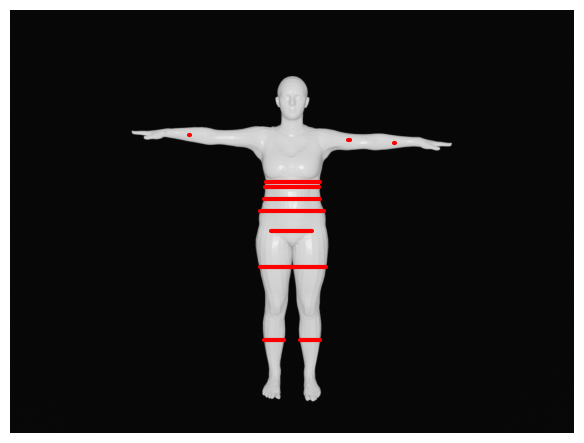

left_biceps_mid_vertical     9.43 cm
left_forearm_mid_vertical    7.75 cm
right_biceps_mid_vertical    9.77 cm
right_forearm_mid_vertical   8.08 cm
chest_band                   33.35 cm
waist_upper                  33.35 cm
waist_mid                    34.69 cm
waist_lower                  39.07 cm
hips_line                    24.93 cm
left_thigh_mid               22.57 cm
right_thigh_mid              21.56 cm
left_calf_mid                12.46 cm
right_calf_mid               12.46 cm


In [24]:
# =========================
# EXAMPLE USAGE (replace with your variables)
# =========================
fkp_n = normalize_keypoints(fkp)
parts_masks, body_mask, overlay = build_part_masks(front, fkp_n)
front_height_px = float(feats.get("front_height_px", 0.0))  # from your feature extractor
HEIGHT_CM = 170.0  # real height if you want cm outputs
measurements = measure_lines_with_vertical_arms(
    front, fkp_n, parts_masks, body_mask,
    front_height_px=front_height_px,
    HEIGHT_CM=HEIGHT_CM,
    plot=True
)
# Print numeric results (in cm if HEIGHT_CM set)
for k, r in measurements.items():
    if r["width_cm"] is None:
        print(f"{k:28s} {r['width_px']:.2f} px")
    else:
        print(f"{k:28s} {r['width_cm']:.2f} cm")


In [26]:
# =========================
# Body-part overlay + measurements (no text on image)
# - Torso/hips/legs: horizontal widths
# - Arms: vertical widths (perpendicular to limb axis)
# =========================

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFilter
import imageio.v2 as imageio

# ------------------ CONFIG ------------------
CFG = dict(
    # limb shapes
    biceps_scale=0.14,   biceps_taper=0.95,
    forearm_scale=0.16,  forearm_taper=0.88,
    thigh_scale=0.22,    thigh_taper=0.95,
    calf_scale=0.24,     calf_taper=0.82,

    elbow_overlap_px=8,
    knee_overlap_px=10,

    # torso / waist controls
    chest_divider_t=0.46,
    waist_top_t=0.52,
    waist_bottom_t=0.82,
    waist_out_px=10,

    # pre-clip growth (px) per part (then clipped to silhouette)
    expand_px={
        "chest": 6, "waist": 8, "hips": 3,
        "left_biceps": 3, "right_biceps": 3,
        "left_forearm": 3, "right_forearm": 3,
        "left_thigh": 5, "right_thigh": 5,
        "left_calf": 5, "right_calf": 5,
    },

    # edge smoothing
    smooth_close_px=3,
)

# ------------------ COCO indices ------------------
K = {
    "nose": 0, "left_eye": 1, "right_eye": 2, "left_ear": 3, "right_ear": 4,
    "left_shoulder": 5, "right_shoulder": 6, "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10, "left_hip": 11, "right_hip": 12,
    "left_knee": 13, "right_knee": 14, "left_ankle": 15, "right_ankle": 16
}

# ------------------ Keypoint helpers ------------------
def normalize_keypoints(kps):
    arr = np.asarray(kps)
    if arr.ndim == 3: arr = arr[0]
    if arr.shape[0] != 17: raise ValueError("Expected 17 keypoints")
    if arr.shape[1] == 2:
        arr = np.concatenate([arr.astype(float), np.ones((17,1), float)], axis=1)
    return arr.astype(float)

def get(kps, idx, conf_thresh=0.2):
    x, y, c = kps[idx]
    return (float(x), float(y)) if c >= conf_thresh else None

def lerp(p, q, t):
    return (p[0]*(1-t) + q[0]*t, p[1]*(1-t) + q[1]*t)

def _safe_unit(vx, vy):
    n = np.hypot(vx, vy)
    return (vx/n, vy/n) if n > 1e-6 else (0.0, 0.0)

# ------------------ Geometry (parts) ------------------
def tapered_quad(p_top, p_bot, scale=0.18, taper=0.85, extra_top=0.0, extra_bot=0.0):
    if p_top is None or p_bot is None: return None
    x1, y1 = p_top; x2, y2 = p_bot
    vx, vy = x2-x1, y2-y1
    L = np.hypot(vx, vy)
    if L < 1e-3: return None
    ux, uy = vx/L, vy/L
    nx, ny = -uy, ux
    x1e, y1e = x1 - ux*extra_top,  y1 - uy*extra_top
    x2e, y2e = x2 + ux*extra_bot,  y2 + uy*extra_bot
    L2 = np.hypot(x2e-x1e, y2e-y1e)
    w_top = L2*scale
    w_bot = w_top*taper
    A = (x1e + nx*w_top, y1e + ny*w_top)
    B = (x2e + nx*w_bot, y2e + ny*w_bot)
    C = (x2e - nx*w_bot, y2e - ny*w_bot)
    D = (x1e - nx*w_top, y1e - ny*w_top)
    return [A,B,C,D]

def _expand_side_outward(L_pt, R_pt, out_px):
    mid = ((L_pt[0] + R_pt[0]) * 0.5, (L_pt[1] + R_pt[1]) * 0.5)
    vL = (L_pt[0] - mid[0], L_pt[1] - mid[1])
    vR = (R_pt[0] - mid[0], R_pt[1] - mid[1])
    uL = _safe_unit(*vL); uR = _safe_unit(*vR)
    L_exp = (L_pt[0] + uL[0]*out_px, L_pt[1] + uL[1]*out_px)
    R_exp = (R_pt[0] + uR[0]*out_px, R_pt[1] + uR[1]*out_px)
    return L_exp, R_exp

def improved_torso_polys(LSh, RSh, LH, RH, chest_div_t, waist_top_t, waist_bot_t, waist_out_px):
    parts = {}
    if not (LSh and RSh and LH and RH): return parts
    # Chest
    L_ch = lerp(LSh, LH, chest_div_t)
    R_ch = lerp(RSh, RH, chest_div_t)
    parts["chest"] = [LSh, RSh, R_ch, L_ch]
    # Waist band
    L_top = lerp(LSh, LH, waist_top_t); R_top = lerp(RSh, RH, waist_top_t)
    L_bot = lerp(LSh, LH, waist_bot_t); R_bot = lerp(RSh, RH, waist_bot_t)
    L_top_e, R_top_e = _expand_side_outward(L_top, R_top, waist_out_px)
    L_bot_e, R_bot_e = _expand_side_outward(L_bot, R_bot, waist_out_px)
    parts["waist"] = [L_top_e, R_top_e, R_bot_e, L_bot_e]
    # Hips band
    torso_h = 0.5*(abs(LH[1]-LSh[1]) + abs(RH[1]-RSh[1]))
    off = 0.05*torso_h
    L_low = (LH[0], LH[1]+off); R_low = (RH[0], RH[1]+off)
    parts["hips"] = [LH, RH, R_low, L_low]
    return parts

# ------------------ Silhouette masks ------------------
def otsu_threshold(gray):
    hist, _ = np.histogram(gray.ravel(), bins=256, range=(0,255))
    total = gray.size; sum_total = np.dot(np.arange(256), hist)
    sumB=wB=0; var_max=0; thresh=0
    for t in range(256):
        wB += hist[t]
        if wB==0: continue
        wF = total - wB
        if wF==0: break
        sumB += t*hist[t]
        mB = sumB/wB
        mF = (sum_total - sumB)/wF
        var_between = wB*wF*(mB-mF)**2
        if var_between > var_max:
            var_max, thresh = var_between, t
    return thresh

def body_mask_from_image(image_path, force_thresh=None):
    img = imageio.imread(image_path)
    gray = (0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]).astype(np.uint8) if img.ndim==3 else img.astype(np.uint8)
    t = int(force_thresh) if force_thresh is not None else otsu_threshold(gray)
    return gray > t  # white body on black bg

def poly_to_mask(shape_hw, poly):
    H, W = shape_hw
    if not poly or len(poly)<3: return np.zeros((H,W), bool)
    m = Image.new("L", (W, H), 0)
    ImageDraw.Draw(m).polygon(poly, outline=1, fill=1)
    return np.array(m, dtype=bool)

def grow_mask(mask, px):
    if px <= 0: return mask
    size = 2*int(px) + 1
    pil = Image.fromarray(mask.astype(np.uint8) * 255)
    grown = pil.filter(ImageFilter.MaxFilter(size=size))
    return (np.array(grown) > 0)

def close_mask(mask, px):
    if px<=0: return mask
    size = 2*int(px)+1
    pil = Image.fromarray(mask.astype(np.uint8)*255)
    dil = pil.filter(ImageFilter.MaxFilter(size=size))
    ero = dil.filter(ImageFilter.MinFilter(size=size))
    return np.array(ero, dtype=np.uint8) > 0

# ------------------ Assemble parts & build masks ------------------
def assemble_improved_parts(kps):
    LSh=get(kps,K["left_shoulder"]);  RSh=get(kps,K["right_shoulder"])
    LE=get(kps,K["left_elbow"]);      RE=get(kps,K["right_elbow"])
    LW=get(kps,K["left_wrist"]);      RW=get(kps,K["right_wrist"])
    LH=get(kps,K["left_hip"]);        RH=get(kps,K["right_hip"])
    LK=get(kps,K["left_knee"]);       RK=get(kps,K["right_knee"])
    LA=get(kps,K["left_ankle"]);      RA=get(kps,K["right_ankle"])

    parts = {}
    parts.update(improved_torso_polys(
        LSh, RSh, LH, RH,
        chest_div_t = CFG["chest_divider_t"],
        waist_top_t = CFG["waist_top_t"],
        waist_bot_t = CFG["waist_bottom_t"],
        waist_out_px= CFG["waist_out_px"]
    ))

    eo = CFG["elbow_overlap_px"]; ko = CFG["knee_overlap_px"]
    parts["left_biceps"]  = tapered_quad(LSh, LE, CFG["biceps_scale"],  CFG["biceps_taper"],  extra_top=6,  extra_bot=eo)
    parts["right_biceps"] = tapered_quad(RSh, RE, CFG["biceps_scale"],  CFG["biceps_taper"],  extra_top=6,  extra_bot=eo)
    parts["left_forearm"] = tapered_quad(LE,  LW, CFG["forearm_scale"], CFG["forearm_taper"], extra_top=eo, extra_bot=6)
    parts["right_forearm"]= tapered_quad(RE,  RW, CFG["forearm_scale"], CFG["forearm_taper"], extra_top=eo, extra_bot=6)
    parts["left_thigh"]   = tapered_quad(LH, LK, CFG["thigh_scale"], CFG["thigh_taper"], extra_top=6, extra_bot=ko)
    parts["right_thigh"]  = tapered_quad(RH, RK, CFG["thigh_scale"], CFG["thigh_taper"], extra_top=6, extra_bot=ko)
    parts["left_calf"]    = tapered_quad(LK, LA, CFG["calf_scale"],  CFG["calf_taper"],  extra_top=ko, extra_bot=6)
    parts["right_calf"]   = tapered_quad(RK, RA, CFG["calf_scale"],  CFG["calf_taper"],  extra_top=ko, extra_bot=6)
    return {n:p for n,p in parts.items() if p is not None}

def build_part_masks(image_path, keypoints):
    img = imageio.imread(image_path)
    H, W = img.shape[:2]
    body = body_mask_from_image(image_path)
    parts = assemble_improved_parts(keypoints)
    overlay = np.zeros((H,W,4), np.uint8)

    parts_masks = {}
    for name, poly in parts.items():
        m = poly_to_mask((H,W), poly)
        grow_px = CFG["expand_px"].get(name, 0)
        if grow_px > 0: m = grow_mask(m, grow_px)
        m = m & body
        m = close_mask(m, CFG["smooth_close_px"])
        parts_masks[name] = m
    return parts_masks, body, overlay

# ------------------ Measurement helpers ------------------
def _row_segment_width(mask_row):
    best = (None, None, 0); n = mask_row.size; i = 0
    while i < n:
        if not mask_row[i]: i += 1; continue
        j = i
        while j < n and mask_row[j]: j += 1
        w = j - i
        if w > best[2]: best = (i, j-1, w)
        i = j
    return best

def _sample_line_points(p0, p1, H, W):
    x0, y0 = p0; x1, y1 = p1
    n = int(max(abs(x1-x0), abs(y1-y0))) + 1
    xs = np.clip(np.rint(np.linspace(x0, x1, n)), 0, W-1).astype(int)
    ys = np.clip(np.rint(np.linspace(y0, y1, n)), 0, H-1).astype(int)
    return xs, ys

def _normal_width_at_midpoint(p_top, p_bot, part_mask, probe_factor=0.9):
    """
    Find widest contiguous run along the normal to p_top->p_bot at its midpoint.
    Returns endpoints (x1,y1)-(x2,y2) and pixel width.
    """
    if p_top is None or p_bot is None:
        return None
    x1, y1 = p_top; x2, y2 = p_bot
    vx, vy = x2 - x1, y2 - y1
    L = float(np.hypot(vx, vy))
    if L < 1e-3:
        return None

    # midpoint and unit normal
    mx, my = (x1 + x2) * 0.5, (y1 + y2) * 0.5
    nx, ny = -vy / L, vx / L

    # probe along the normal
    half = probe_factor * L * 0.5
    pA = (mx - nx * half, my - ny * half)
    pB = (mx + nx * half, my + ny * half)

    H, W = part_mask.shape
    xs, ys = _sample_line_points(pA, pB, H, W)
    vals = part_mask[ys, xs]

    # longest contiguous True
    best = (None, None, 0)
    i = 0; n = len(vals)
    while i < n:
        if not vals[i]:
            i += 1; continue
        j = i
        while j < n and vals[j]:
            j += 1
        w = j - i
        if w > best[2]:
            best = (i, j-1, w)
        i = j

    i0, i1, w = best
    if w <= 0: return None
    xA, yA = float(xs[i0]), float(ys[i0])
    xB, yB = float(xs[i1]), float(ys[i1])
    return (xA, yA, xB, yB, float(w))

# ------------------ Main measurement (arms vertical) ------------------
def measure_lines_with_vertical_arms(front_image_path, keypoints, parts_masks, body_mask,
                                     front_height_px, HEIGHT_CM=None, plot=True):
    """
    Returns dict of measurements.
      - Torso/Hips/Legs keys store: {y, xL, xR, width_px, width_cm}
      - Arm keys store: {x1,y1,x2,y2,width_px,width_cm}
    """
    k = keypoints
    H, W = body_mask.shape
    results = {}

    px_to_cm = None
    if HEIGHT_CM is not None and front_height_px and front_height_px > 0:
        px_to_cm = float(HEIGHT_CM) / float(front_height_px)

    # keypoints
    LSh=get(k,K["left_shoulder"]);  RSh=get(k,K["right_shoulder"])
    LE=get(k,K["left_elbow"]);      RE=get(k,K["right_elbow"])
    LW=get(k,K["left_wrist"]);      RW=get(k,K["right_wrist"])
    LH=get(k,K["left_hip"]);        RH=get(k,K["right_hip"])
    LK=get(k,K["left_knee"]);       RK=get(k,K["right_knee"])
    LA=get(k,K["left_ankle"]);      RA=get(k,K["right_ankle"])

    # ---- Arms (vertical / normal-to-limb) ----
    if LSh and LE and "left_biceps" in parts_masks:
        res = _normal_width_at_midpoint(LSh, LE, parts_masks["left_biceps"], 0.9)
        if res:
            xA,yA,xB,yB,w = res
            results["left_biceps_mid_vertical"] = dict(
                x1=xA,y1=yA,x2=xB,y2=yB,width_px=w,
                width_cm=(w*px_to_cm if px_to_cm else None)
            )
    if LE and LW and "left_forearm" in parts_masks:
        res = _normal_width_at_midpoint(LE, LW, parts_masks["left_forearm"], 0.9)
        if res:
            xA,yA,xB,yB,w = res
            results["left_forearm_mid_vertical"] = dict(
                x1=xA,y1=yA,x2=xB,y2=yB,width_px=w,
                width_cm=(w*px_to_cm if px_to_cm else None)
            )
    if RSh and RE and "right_biceps" in parts_masks:
        res = _normal_width_at_midpoint(RSh, RE, parts_masks["right_biceps"], 0.9)
        if res:
            xA,yA,xB,yB,w = res
            results["right_biceps_mid_vertical"] = dict(
                x1=xA,y1=yA,x2=xB,y2=yB,width_px=w,
                width_cm=(w*px_to_cm if px_to_cm else None)
            )
    if RE and RW and "right_forearm" in parts_masks:
        res = _normal_width_at_midpoint(RE, RW, parts_masks["right_forearm"], 0.9)
        if res:
            xA,yA,xB,yB,w = res
            results["right_forearm_mid_vertical"] = dict(
                x1=xA,y1=yA,x2=xB,y2=yB,width_px=w,
                width_cm=(w*px_to_cm if px_to_cm else None)
            )

    # ---- Torso/Hips (horizontal) ----
    def _avg(vals):
        vals = [v for v in vals if v is not None]
        return float(np.mean(vals)) if vals else None

    def _y_between(p_top, p_bot, t):
        return p_top[1]*(1-t) + p_bot[1]*t

    if LSh and RSh and LH and RH:
        def y_t(t): return _avg([_y_between(LSh, LH, t), _y_between(RSh, RH, t)])
        chest_t  = CFG["chest_divider_t"] + 0.02
        waist_t1 = CFG["waist_top_t"] + 0.02
        waist_t2 = 0.5*(CFG["waist_top_t"] + CFG["waist_bottom_t"])
        waist_t3 = CFG["waist_bottom_t"] - 0.02
        torso_lines = [
            ("chest_band", "chest", y_t(chest_t)),
            ("waist_upper", "waist", y_t(waist_t1)),
            ("waist_mid",   "waist", y_t(waist_t2)),
            ("waist_lower", "waist", y_t(waist_t3)),
            ("hips_line",   "hips",  _avg([LH[1], RH[1]]) + 2.0),
        ]
        for name, mask_name, y in torso_lines:
            if y is None: continue
            y_int = int(round(np.clip(y, 0, H-1)))
            m = parts_masks.get(mask_name, body_mask)
            row = m[y_int, :]
            xL, xR, w = _row_segment_width(row)
            if w > 0:
                results[name] = dict(
                    y=float(y_int), xL=float(xL), xR=float(xR), width_px=float(w),
                    width_cm=(float(w)*(px_to_cm if px_to_cm else 1.0) if px_to_cm else None)
                )

    # ---- Legs (horizontal) ----
    def _measure_side(mask_name, y):
        if y is None: return None
        y_int = int(round(np.clip(y, 0, H-1)))
        m = parts_masks.get(mask_name, body_mask)
        row = m[y_int, :]
        xL, xR, w = _row_segment_width(row)
        if w <= 0: return None
        return dict(
            y=float(y_int), xL=float(xL), xR=float(xR), width_px=float(w),
            width_cm=(float(w)*px_to_cm if px_to_cm else None)
        )

    if LH and LK:
        yL = (LH[1] + LK[1]) * 0.5
        r = _measure_side("left_thigh", yL)
        if r: results["left_thigh_mid"] = r
    if RH and RK:
        yR = (RH[1] + RK[1]) * 0.5
        r = _measure_side("right_thigh", yR)
        if r: results["right_thigh_mid"] = r
    if LK and LA:
        yL = (LK[1] + LA[1]) * 0.5
        r = _measure_side("left_calf", yL)
        if r: results["left_calf_mid"] = r
    if RK and RA:
        yR = (RK[1] + RA[1]) * 0.5
        r = _measure_side("right_calf", yR)
        if r: results["right_calf_mid"] = r

    # ---- Plot only lines (no text) ----
    if plot:
        img = imageio.imread(front_image_path)
        plt.figure(figsize=(6,8))
        plt.imshow(img)

        # torso/hips/legs (horizontal)
        for name, r in results.items():
            if "vertical" in name: 
                continue
            plt.plot([r["xL"], r["xR"]], [r["y"], r["y"]], color="red", linewidth=3)

        # arms (draw chord endpoints along the normal)
        for name, r in results.items():
            if "vertical" not in name:
                continue
            plt.plot([r["x1"], r["x2"]], [r["y1"], r["y2"]], color="red", linewidth=3)

        plt.axis("off"); plt.tight_layout(); plt.show()

    return results




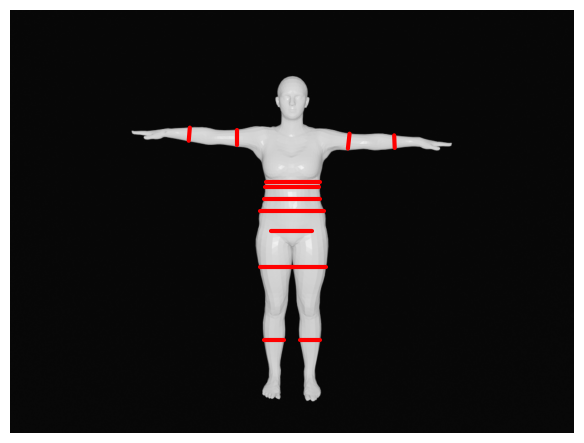

left_biceps_mid_vertical     9.43 cm
left_forearm_mid_vertical    7.75 cm
right_biceps_mid_vertical    9.77 cm
right_forearm_mid_vertical   8.08 cm
chest_band                   33.35 cm
waist_upper                  33.35 cm
waist_mid                    34.69 cm
waist_lower                  39.07 cm
hips_line                    24.93 cm
left_thigh_mid               22.57 cm
right_thigh_mid              21.56 cm
left_calf_mid                12.46 cm
right_calf_mid               12.46 cm


In [27]:
# =========================
# EXAMPLE USAGE
# =========================
# Assumes you already have:
#  - front: path to the raw front image (without prior drawings)
#  - fkp:   YOLOv8 keypoints for that image (shape [17,3] or [1,17,3])
#
fkp_n = normalize_keypoints(fkp)
parts_masks, body_mask, _ = build_part_masks(front, fkp_n)

# If you want centimeters, pass real height and the pixel height used in features:
front_height_px = float(feats.get("front_height_px", 0.0))  # from your feature extractor
HEIGHT_CM = 170.0  # put subject's real height here, or set to None to keep px

measurements = measure_lines_with_vertical_arms(
    front, fkp_n, parts_masks, body_mask,
    front_height_px=front_height_px,
    HEIGHT_CM=HEIGHT_CM,
    plot=True
)

# Show numeric outputs
for k, v in measurements.items():
    unit = "cm" if (v.get("width_cm") is not None) else "px"
    val  = v.get("width_cm", v.get("width_px"))
    print(f"{k:28s} {val:.2f} {unit}")